In [23]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import math
import time
from datetime import datetime

import matplotlib.pyplot as plt

from scipy.optimize import minimize

# Algotithm: Distributionally Robust Path Integral


![xx](figure/algorithm.png)

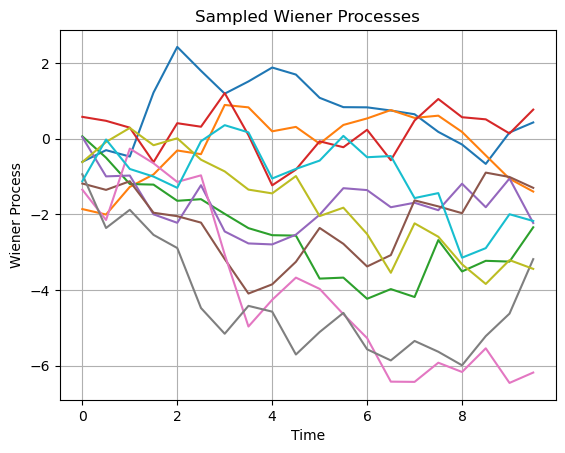

In [24]:
def sample_wiener_process(T, dt, num_trajs, n=2):
    Sigma = np.eye(n)  # Covariance matrix for Wiener process
    time_steps = int(T / dt)
    noise_samples = np.random.multivariate_normal(np.zeros(n), Sigma, size=(num_trajs, time_steps))
    W = np.cumsum(noise_samples, axis=1) * np.sqrt(dt)  # Accumulate increments to get Wiener process
    return W, noise_samples

# Set parameters
T = 10.0  # Total time duration
dt = 0.5  # Time step size
num_trajs = 5  # Number of Wiener process trajectories

# Generate Wiener process samples
W, noise_sample = sample_wiener_process(T, dt, num_trajs)

# Plot Wiener process samples
t = np.arange(0, T, dt)
for i in range(num_trajs):
    plt.plot(t, W[i])
plt.xlabel('Time')
plt.ylabel('Wiener Process')
plt.title('Sampled Wiener Processes')
plt.grid(True)
plt.show()


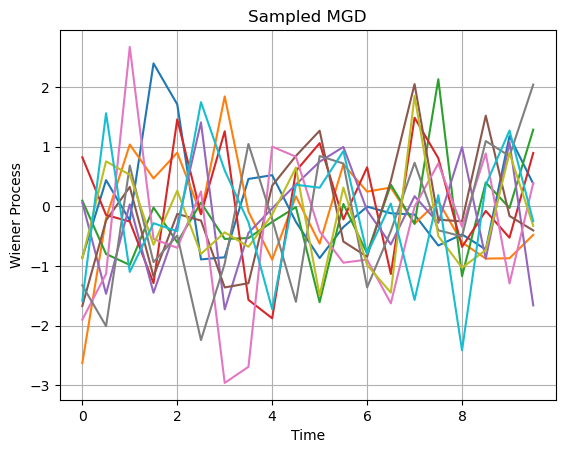

In [25]:
# Plot Wiener process samples
t = np.arange(0, T, dt)
for i in range(num_trajs):
    plt.plot(t, noise_sample[i])
plt.xlabel('Time')
plt.ylabel('Wiener Process')
plt.title('Sampled MGD')
plt.grid(True)
plt.show()

The algorithm appears to be a type of control algorithm, specifically a variant of Path Integral Stochastic Optimal Control, which is designed to find the optimal control sequence $u^*(t)$ for a dynamic system over a certain period of time $T_{\Delta}$, under uncertainty in the dynamics.


1. **Inputs**: 
   - The initial state of the system $\mathbf{x}(0)$
   - A set of candidate $\lambda$'s, which are typically parameters in robust control algorithms that adjust the trade-off between the expectation and the variance of the cost
   - The sample mean vector and covariance based on $N$ historical data points $\hat{\Xi}^N$
   - A robustness parameter $\gamma$
   - The number of generated sample trajectories $K$
   - The number of time steps $T_{\Delta}$.

2. **Outputs**:
   - The optimal control sequence $u^*(t)$ for $t = 0,1, \dots, T_{\Delta} - 1$

3. The algorithm begins by sampling $K$ trajectories $\xi^k(t)$ for $t = 0,1, \dots, T_{\Delta} - 1$

4. For each time step $t$, the state of the system $\mathbf{x}(t + 1)$ is updated according to a function $f$, which represents the dynamics of the system, and a function $G$, which represents the control influence on the system. The variable $\xi^k(t)$ is a random disturbance at time $t$ in the $k$th sample trajectory.

5. Depending on the time step, either the stage cost $s(\mathbf{x}(t))$ or the terminal cost $\psi(\mathbf{x}(t))$ is added to a cumulative cost $S^k$ for the $k$th trajectory.

6. For each candidate $\lambda_m$, a quantity $\eta_m$ is computed, which is a function of the exponential of the negative scaled costs across all sample trajectories. This is reminiscent of the softmax function and can be seen as a way to convert the costs to a probability distribution over trajectories.

7. The $\lambda$ that minimizes $\eta_m$ is selected, and the weights $w^k$ for each trajectory are computed based on this $\lambda_{m^*}$ and the costs of each trajectory.

8. Finally, the optimal control at each time step $u^*(t)$ is computed as a weighted sum of the disturbances at that time step across all sample trajectories, using the weights computed in the previous step.

This algorithm is intended to be "distributionally robust", meaning it is designed to perform well under a wide range of possible probability distributions for the disturbances $\xi^k(t)$. The use of the parameter $\lambda$ and the computation of weights for each trajectory can be seen as a way to handle the uncertainty in the distribution of the disturbances.

# Code

In [26]:
def sample_noise(Sigma, T=10.0, dt=0.5, num_trajs=500, n=2) :
    if len(Sigma) != n :
        n = len(Sigma)
    time_steps = math.floor(T/dt)
    mu = np.zeros(n)
    mask_mu = np.random.randn(n)
    noise_samples = np.random.multivariate_normal(mu, Sigma , [num_trajs,time_steps])
    W = np.cumsum(noise_samples, axis=1) * np.sqrt(dt)  # Accumulate increments to get Wiener process
    #return W
    return noise_samples

def stage_cost(dist2, dist_weight = 10) :
    return dist_weight*dist2

def term_cost(dist2, goal_reached) :
    return (1 - float(goal_reached)) * dist2

def compute_lambda_theta(theta) :
    return 1/(1 - theta)



In [27]:
def rollout(x0, x_goal, u_curr, obs_pos, obs_r, T, dt, theta, noise_samples, dist_weight, Sigma, obs_cost = 10, num_trajs=500, goal_tolerance=0.1) :
    costs = np.zeros(num_trajs)
    # time_steps = len(u_curr) # Haven't defined u_curr yet
    time_steps = int(T//dt)
    goal_reached = False
    goal_tolerance_sq = goal_tolerance ** 2
    dist_to_goal2 = 1e9
    
    x_vis = np.zeros( (20, time_steps, 2) )*np.nan
    n = len(x0)
    
    for k in range(num_trajs) :
        x_curr = np.zeros(n)
        for i in range(n) :
            x_curr[i] = x0[i]
        if k < 20 :
            x_vis[k, 0, :] = x_curr[:2]  
            
        ## new terms  use mu_hat
        for t in range(time_steps) :
            x_curr +=np.array([[0, 0, dt, 0],[0, 0, 0, dt],[0, 0, 0, 0],[0, 0, 0, 0]]) @ x_curr + np.array([[(dt**2)/2, 0],[0, (dt**2)/2],[dt, 0],[0, dt]]) @ (noise_samples[k,t,:])    
            
            if k < 20 :
                x_vis[k, t, :] = x_curr[:2]    
                
            dist_to_goal2 = (x_goal[0]-x_curr[0])**2 + (x_goal[1]-x_curr[1])**2
            if dist_to_goal2 < 0.01 :
                costs[k] += stage_cost(dist_to_goal2, dist_weight)
                break
            else :
                costs[k] += stage_cost(dist_to_goal2, dist_weight)
                num_obs = len(obs_pos)
                for obs_i in range(num_obs) :
                    op = obs_pos[obs_i]
                    costs[k] += float(x_curr[0] > op[0] and x_curr[0] < op[0] + obs_r[obs_i] and 
                                      x_curr[1] > op[1] and x_curr[1] < op[1] + obs_r[obs_i]) * obs_cost 
                
                # Boundary panalty
                costs[k] += float(x_curr[0] < -4 or x_curr[0] > 1  or
                                  x_curr[1] < -1 or x_curr[1] > 4 )  * obs_cost 
                
                
            if dist_to_goal2 <= goal_tolerance_sq :
                goal_reached = True
                break
            
            # Terminal cost
            costs[k] += term_cost(dist_to_goal2, goal_reached) 
            
            # for t in range(time_steps) :
            #     costs[k] += u_curr[t,:] @ Sigma @ u_curr[t,:]
    return costs, x_vis

# Optimization Algorithms Options

In [28]:
def update_useq_risk_neutral(costs, u_curr, noise_samples, T, dt, lambda_neut=100, n=2) :
    # 100 
    costs = np.exp( - (costs) / lambda_neut ) 
    sum_costs = np.sum(costs)    
    
 
    time_steps = math.floor(T/dt)
    u_curr = np.zeros((time_steps,n))
    for t in range(time_steps) :
        for k in range(len(costs)) :
            u_curr[t,:] += (costs[k] / sum_costs ) * noise_samples[k,t,:] 

    return u_curr

def update_useq_bisection(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2) :    
    num_trajs = len(noise_samples)
    for gamma in gammas :
        lambda_l = 1e-3; lambda_r = 1e3
        # theta_l = -1e10; theta_r = 1e10 
        k = 0
        K = 300        
        while k < K :
            lambda_1 = lambda_l + (lambda_r - lambda_l) / 3
            lambda_2 = lambda_l + 2 * (lambda_r - lambda_l) / 3
            
            opt_cost_1 = gamma / lambda_1 - lambda_1 * np.log( 1/num_trajs * np.sum( np.exp( -costs / lambda_1)  ) )
            opt_cost_2 = gamma / lambda_2 - lambda_2 * np.log( 1/num_trajs * np.sum( np.exp( -costs / lambda_2 )  ) )
            # print(- lambda_1 * np.log( 1/num_trajs * np.sum( np.exp( -costs / lambda_1)  ) ))
            
            if opt_cost_1 > opt_cost_2:
                lambda_l = lambda_1
            elif opt_cost_1 < opt_cost_2 :
                lambda_r = lambda_2
            
            if lambda_r - lambda_l <= 1e-3:
                break
            
            optimal_cost = min(opt_cost_1, opt_cost_2)
            k += 1

    # if init_report == 0 :
    if init_report % 10 == 0 :
        print(lambda_r)
    
    # min_cost = np.min(costs)
    # costs = np.exp( - (costs - min_cost) / lambda_r ) 
    costs = np.exp( - (costs ) / lambda_r ) 
    sum_costs = np.sum(costs)
    
    time_steps = math.floor(T/dt)
    u_curr = np.zeros((time_steps,n))    
    for k in range(len(costs)) :
        u_curr[0,:] += (costs[k] / sum_costs ) * noise_samples[k,0,:] 
    
    return u_curr

def update_useq_grid_search(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2) :
    num_trajs = len(noise_samples)
    lambda_grid = np.linspace(1e-3, 1e3, num_trajs)  # grid of lambda values
    for gamma in gammas :
        opt_costs = []
        for lambda_ in lambda_grid:
            opt_cost = gamma / lambda_ - lambda_ * np.log(1/num_trajs * np.sum(np.exp(-costs / lambda_)))
            opt_costs.append(opt_cost)
        lambda_r = lambda_grid[np.argmin(opt_costs)]  # Select the lambda that gives the minimum cost

        costs = np.exp(-costs / lambda_r) 
        sum_costs = np.sum(costs)

        time_steps = math.floor(T/dt)
        u_curr = np.zeros((time_steps,n))    
        for k in range(len(costs)) :
            u_curr[0,:] += (costs[k] / sum_costs ) * noise_samples[k,0,:] 

    return u_curr



def update_useq_NM(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2):
    num_trajs = len(noise_samples)

    # Define the cost function wrapper
    def opt_cost_func(lambda_, gamma, costs, num_trajs):
        denominator = 1 / num_trajs * np.sum(np.exp(-costs / lambda_))
        if denominator == 0:
            return np.inf  # Return a large value to indicate failure
        return gamma / lambda_ - lambda_ * np.log(denominator)

    for gamma in gammas:
        # Alternatively, use the Nelder-Mead method.  'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov'
        result = minimize(opt_cost_func, x0=1.0, args=(gamma, costs, num_trajs), method='Powell', options={'maxiter': 10000})

        if result.success:
            lambda_r = result.x[0]
        else:
            print("Optimization failed for gamma =", gamma)
            continue  # Move on to the next gamma if optimization failed

        costs = np.exp(-costs / lambda_r)
        sum_costs = np.sum(costs)

        time_steps = math.floor(T / dt)
        u_curr = np.zeros((time_steps, n))
        for k in range(len(costs)):
            u_curr[0, :] += (costs[k] / sum_costs) * noise_samples[k, 0, :]

    return u_curr


# Path Integral

In [29]:
def path_integral(Sigma, x0, x_goal, u_curr, dist_weight, obs_cost, obs_pos, obs_r, T, dt, theta, num_trajs, init_report, gammas):
    
    noise_samples = sample_noise(Sigma, T, dt, num_trajs, n=2)
    costs, x_vis = rollout(x0, x_goal, u_curr, obs_pos, obs_r, T, dt, theta, noise_samples, dist_weight, Sigma, obs_cost, num_trajs, goal_tolerance=0.1)   
    # u_curr = update_useq_risk_neutral(costs, u_curr, noise_samples, T, dt, lambda_neut=100, n=2)
    # u_curr = update_useq_bisection(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    # u_curr = update_useq_grid_search(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    u_curr = update_useq_NM(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    
    return u_curr, x_vis

# `GMM`

Generates control noise samples from a Gaussian Mixture Model (GMM) based on given means, covariances, and probabilities.

In [30]:
# delete

def GMM(true_mus, true_covs, true_probs) :
    acc_probs = [np.sum(true_probs[:i]) for i in range(1, len(true_probs)+1)]   
    r = np.random.uniform(0,1)
    k = 0
    for i, threshold in enumerate(acc_probs):
        if r < threshold:
            k = i
            break
    selected_mu = true_mus[k]
    selected_cov = true_covs[k]
    contorl_noise =  np.random.multivariate_normal(selected_mu,selected_cov)
    
    return contorl_noise

- Sets up some parameters for the simulation, such as the number of simulations, maximum number of steps, and arrays to store the history of states and success/failure indices.

In [31]:
true_mus = np.array([[-0.1, 0],[0.1, 0]])
true_mus = np.random.randn(*true_mus.shape) * 0.01

true_covs = np.array([[[0.01,0],[0,0.01]],[[0.01,0],[0,0.01]]])
true_covs = np.random.randn(*true_covs.shape) * 0.01
true_probs = np.array([0.5, 0.5])

num_simulation = 10
max_steps = 600
x_hists = np.zeros( (num_simulation, max_steps+1, 2) )*np.nan
success_time = []
success_index = []
fail_index = []

In [32]:
true_mus

array([[-0.01088952,  0.01635149],
       [ 0.0042326 ,  0.01860998]])

Inside a loop for each simulation, the code sets up the initial and goal states, generates errors from a GMM, and calculates the covariance matrix based on the errors.

The simulation loop iterates over time steps and performs the following steps:

- Calls the `path_integral` function to update the control sequence based on the current state, goal state, and other parameters.
- Simulates the stochastic dynamics of the system under control channel noise and updates the state accordingly.
- Checks for collisions with obstacles and the boundary and terminates the simulation if a collision occurs.
- Checks if the goal state has been reached and terminates the simulation if it has.
- Stores the state and control history for visualization purposes.



/var/folders/lf/cvhsltm529q5zyt6s5vt08l00000gn/T/ipykernel_14638/2762345755.py:84: RuntimeWarning: overflow encountered in exp
  denominator = 1 / num_trajs * np.sum(np.exp(-costs / lambda_))
/usr/local/Caskroom/miniconda/base/envs/Lab/lib/python3.11/site-packages/scipy/optimize/_optimize.py:3382: RuntimeWarning: invalid value encountered in scalar subtract
  t = 2.0*(fx + fx2 - 2.0*fval)
/usr/local/Caskroom/miniconda/base/envs/Lab/lib/python3.11/site-packages/scipy/optimize/_optimize.py:3383: RuntimeWarning: invalid value encountered in subtract
  temp = (fx - fval - delta)
/usr/local/Caskroom/miniconda/base/envs/Lab/lib/python3.11/site-packages/scipy/optimize/_optimize.py:3386: RuntimeWarning: invalid value encountered in scalar multiply
  t -= delta*temp*temp


Hit obstacle


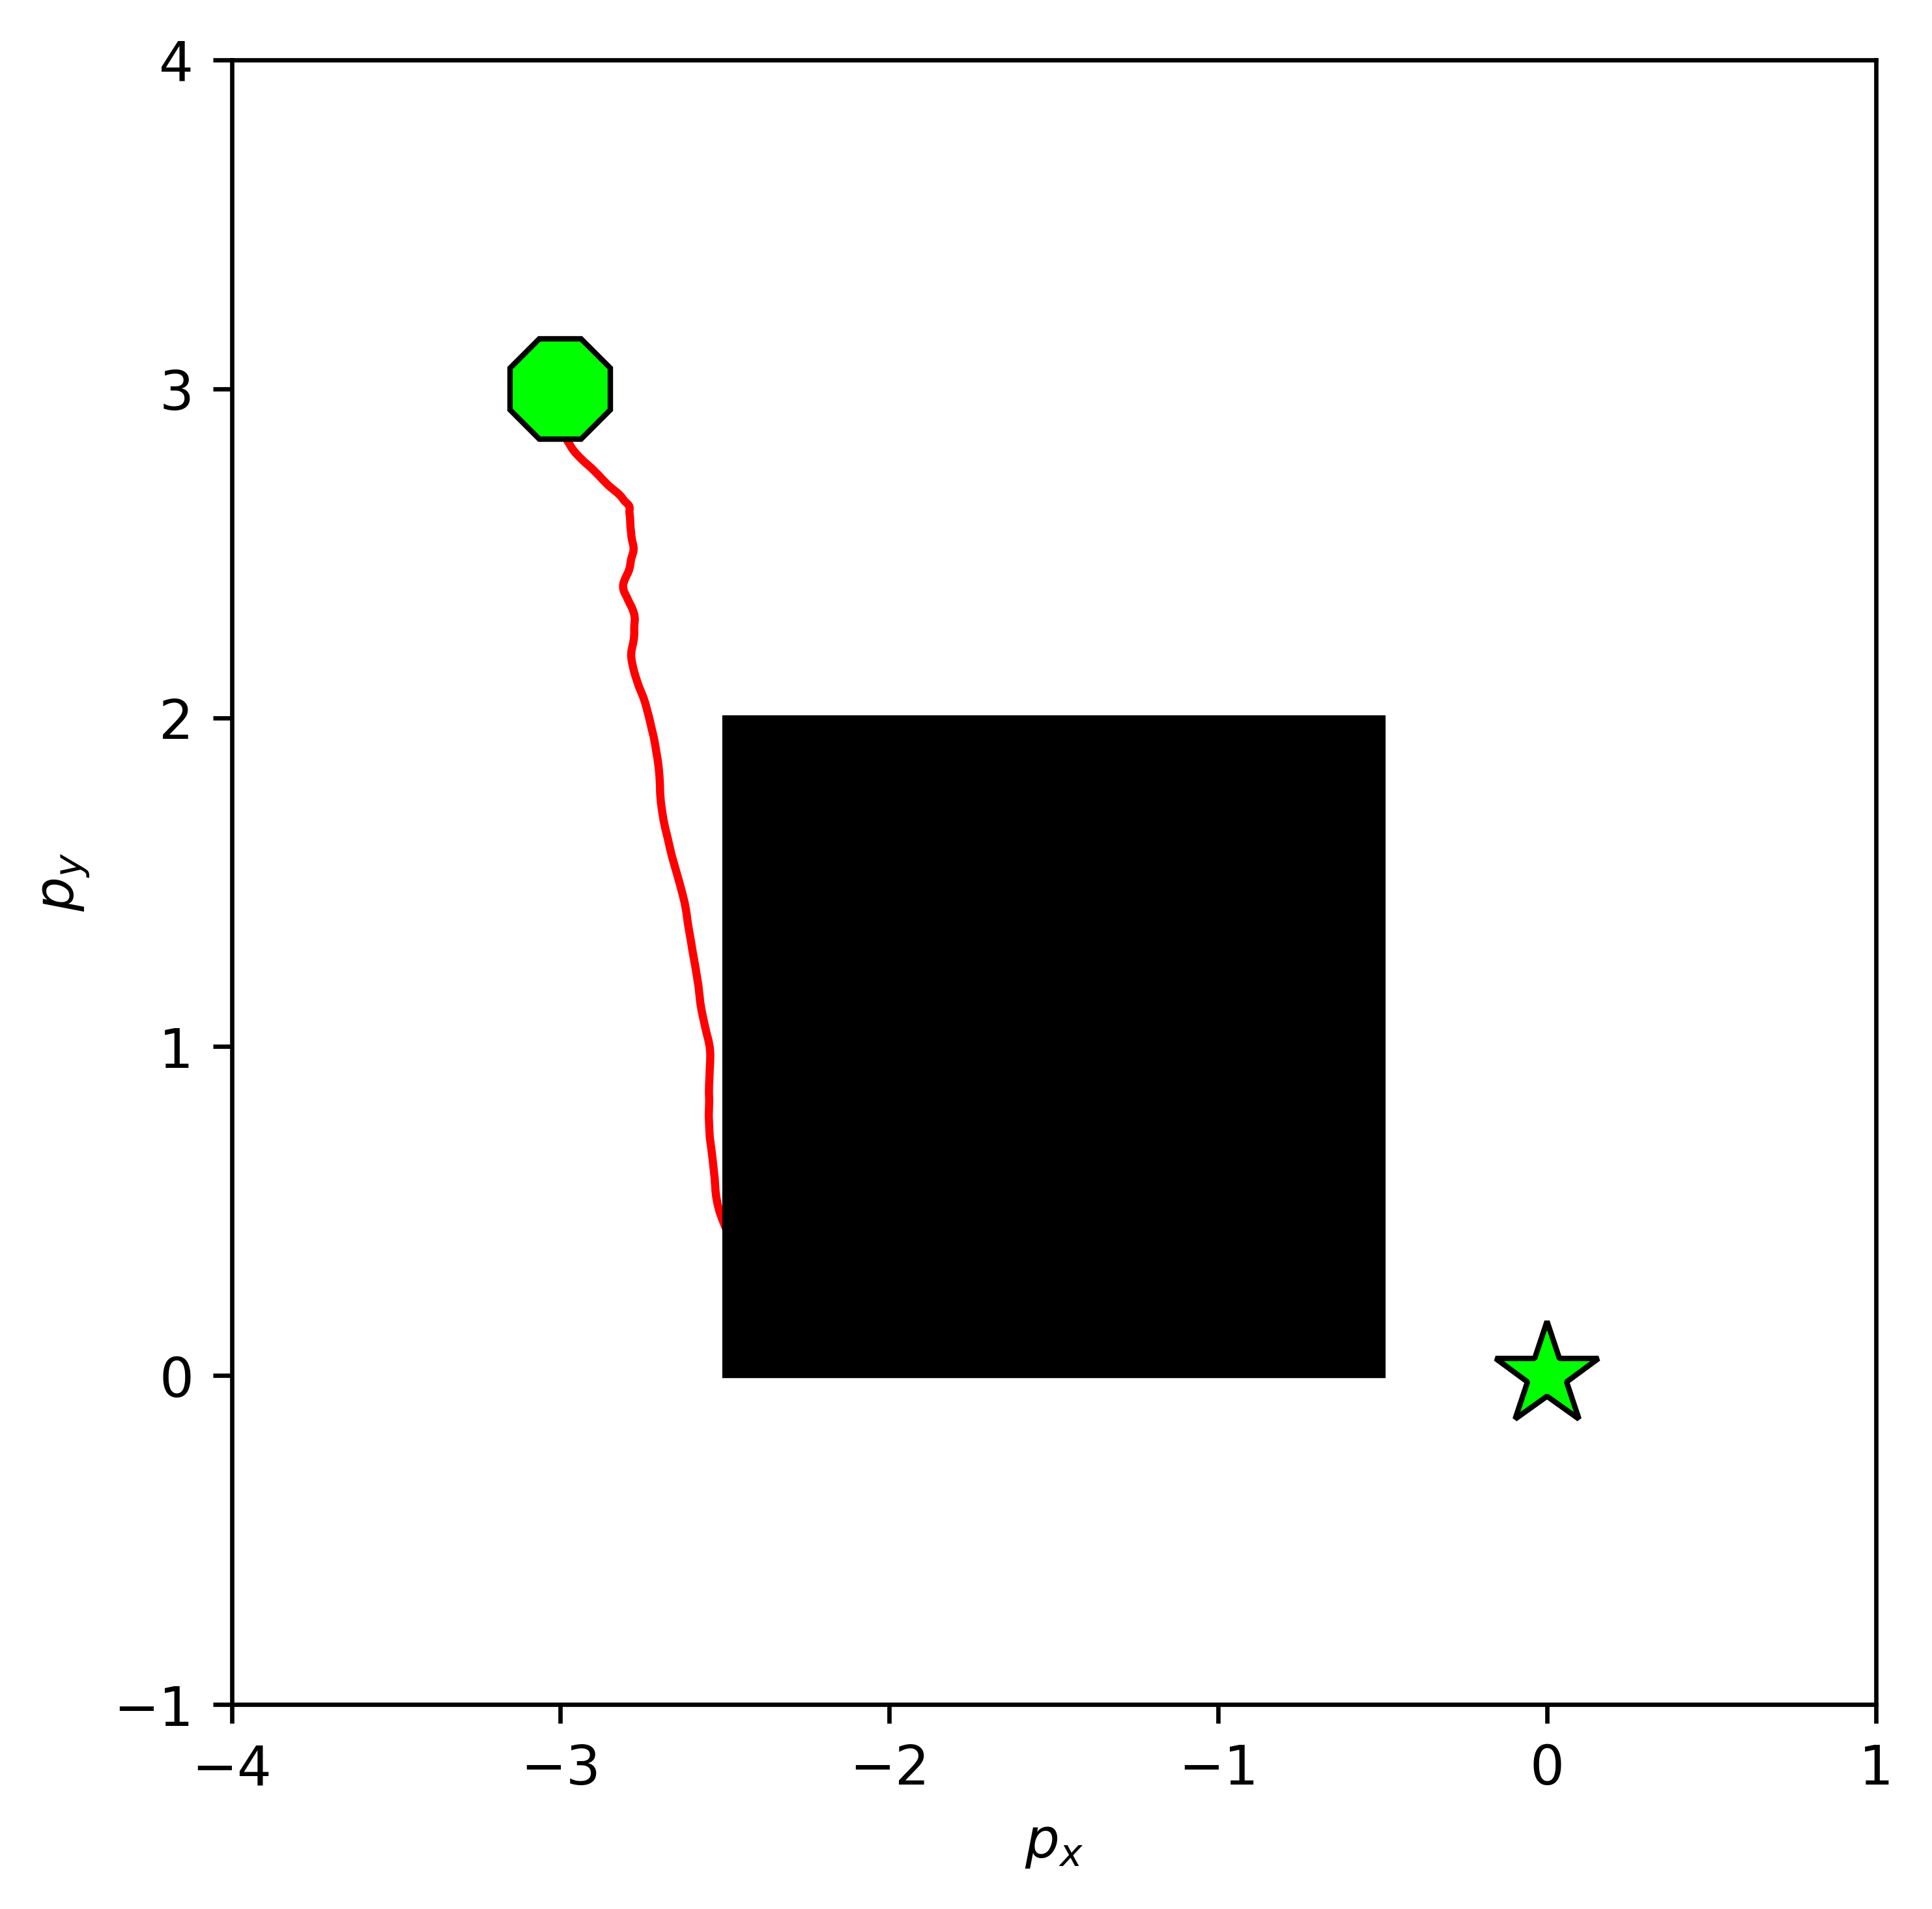

Goal reached at t=35.10s


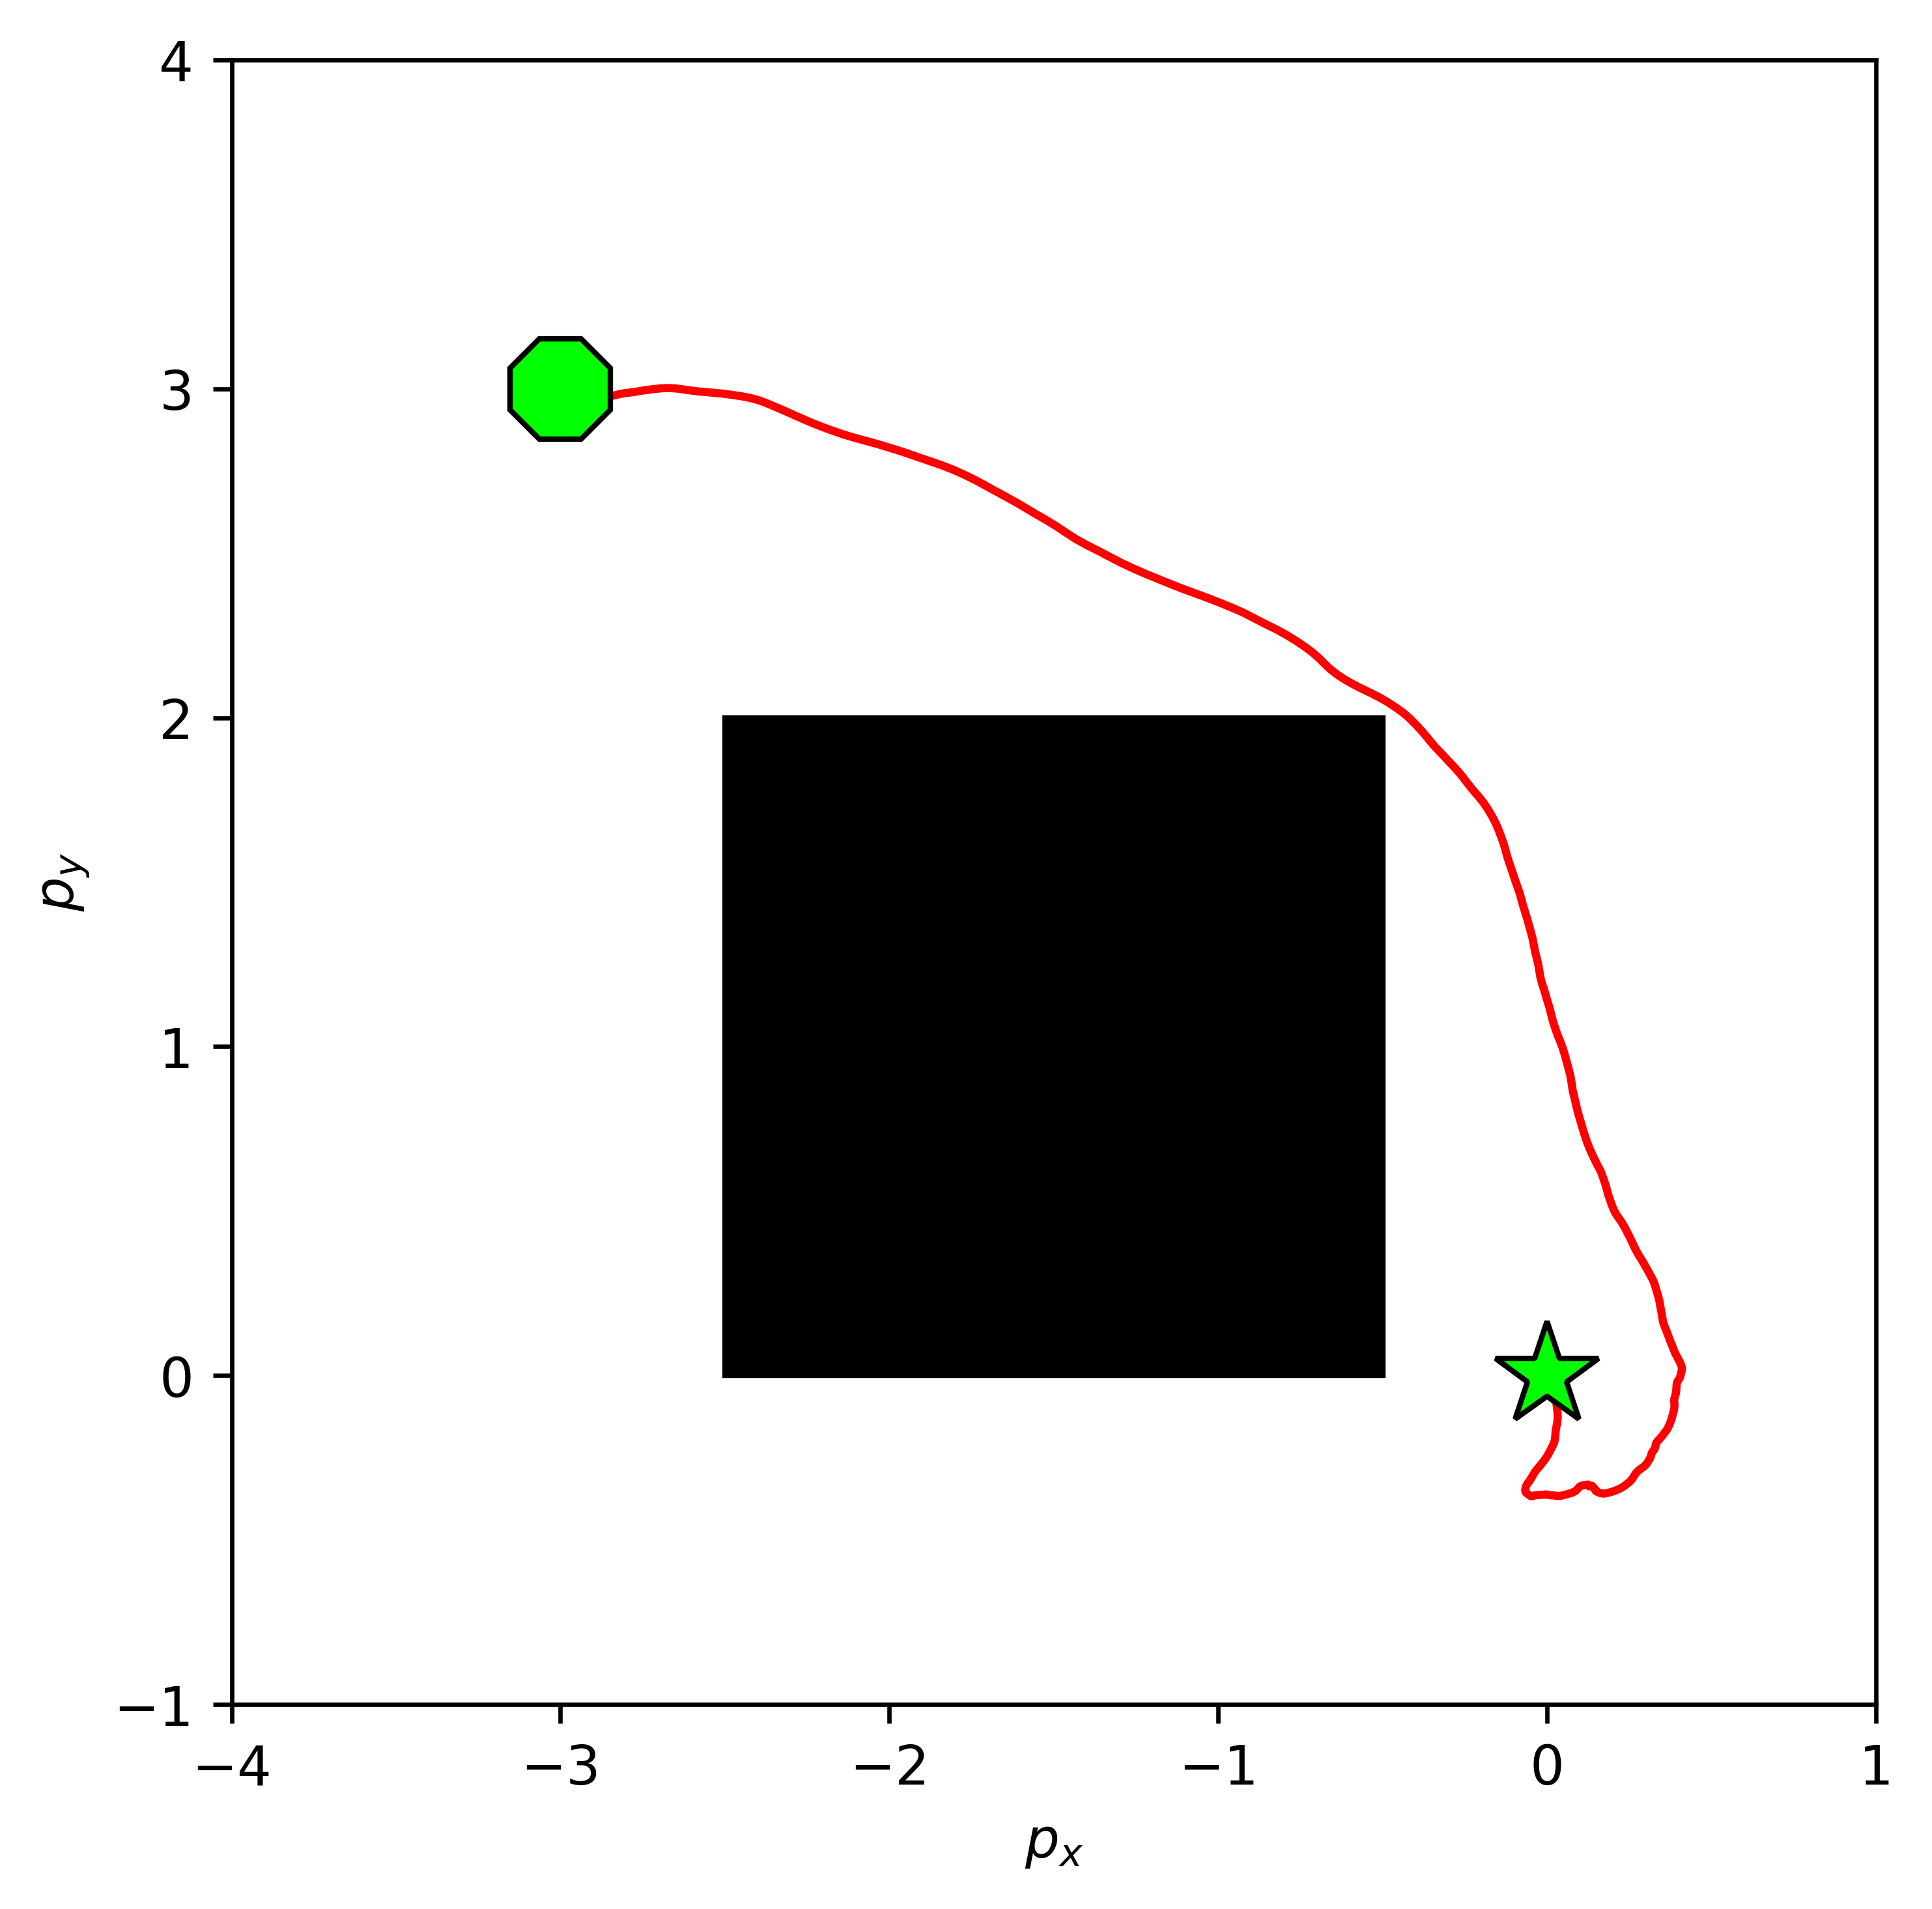

Goal reached at t=26.30s


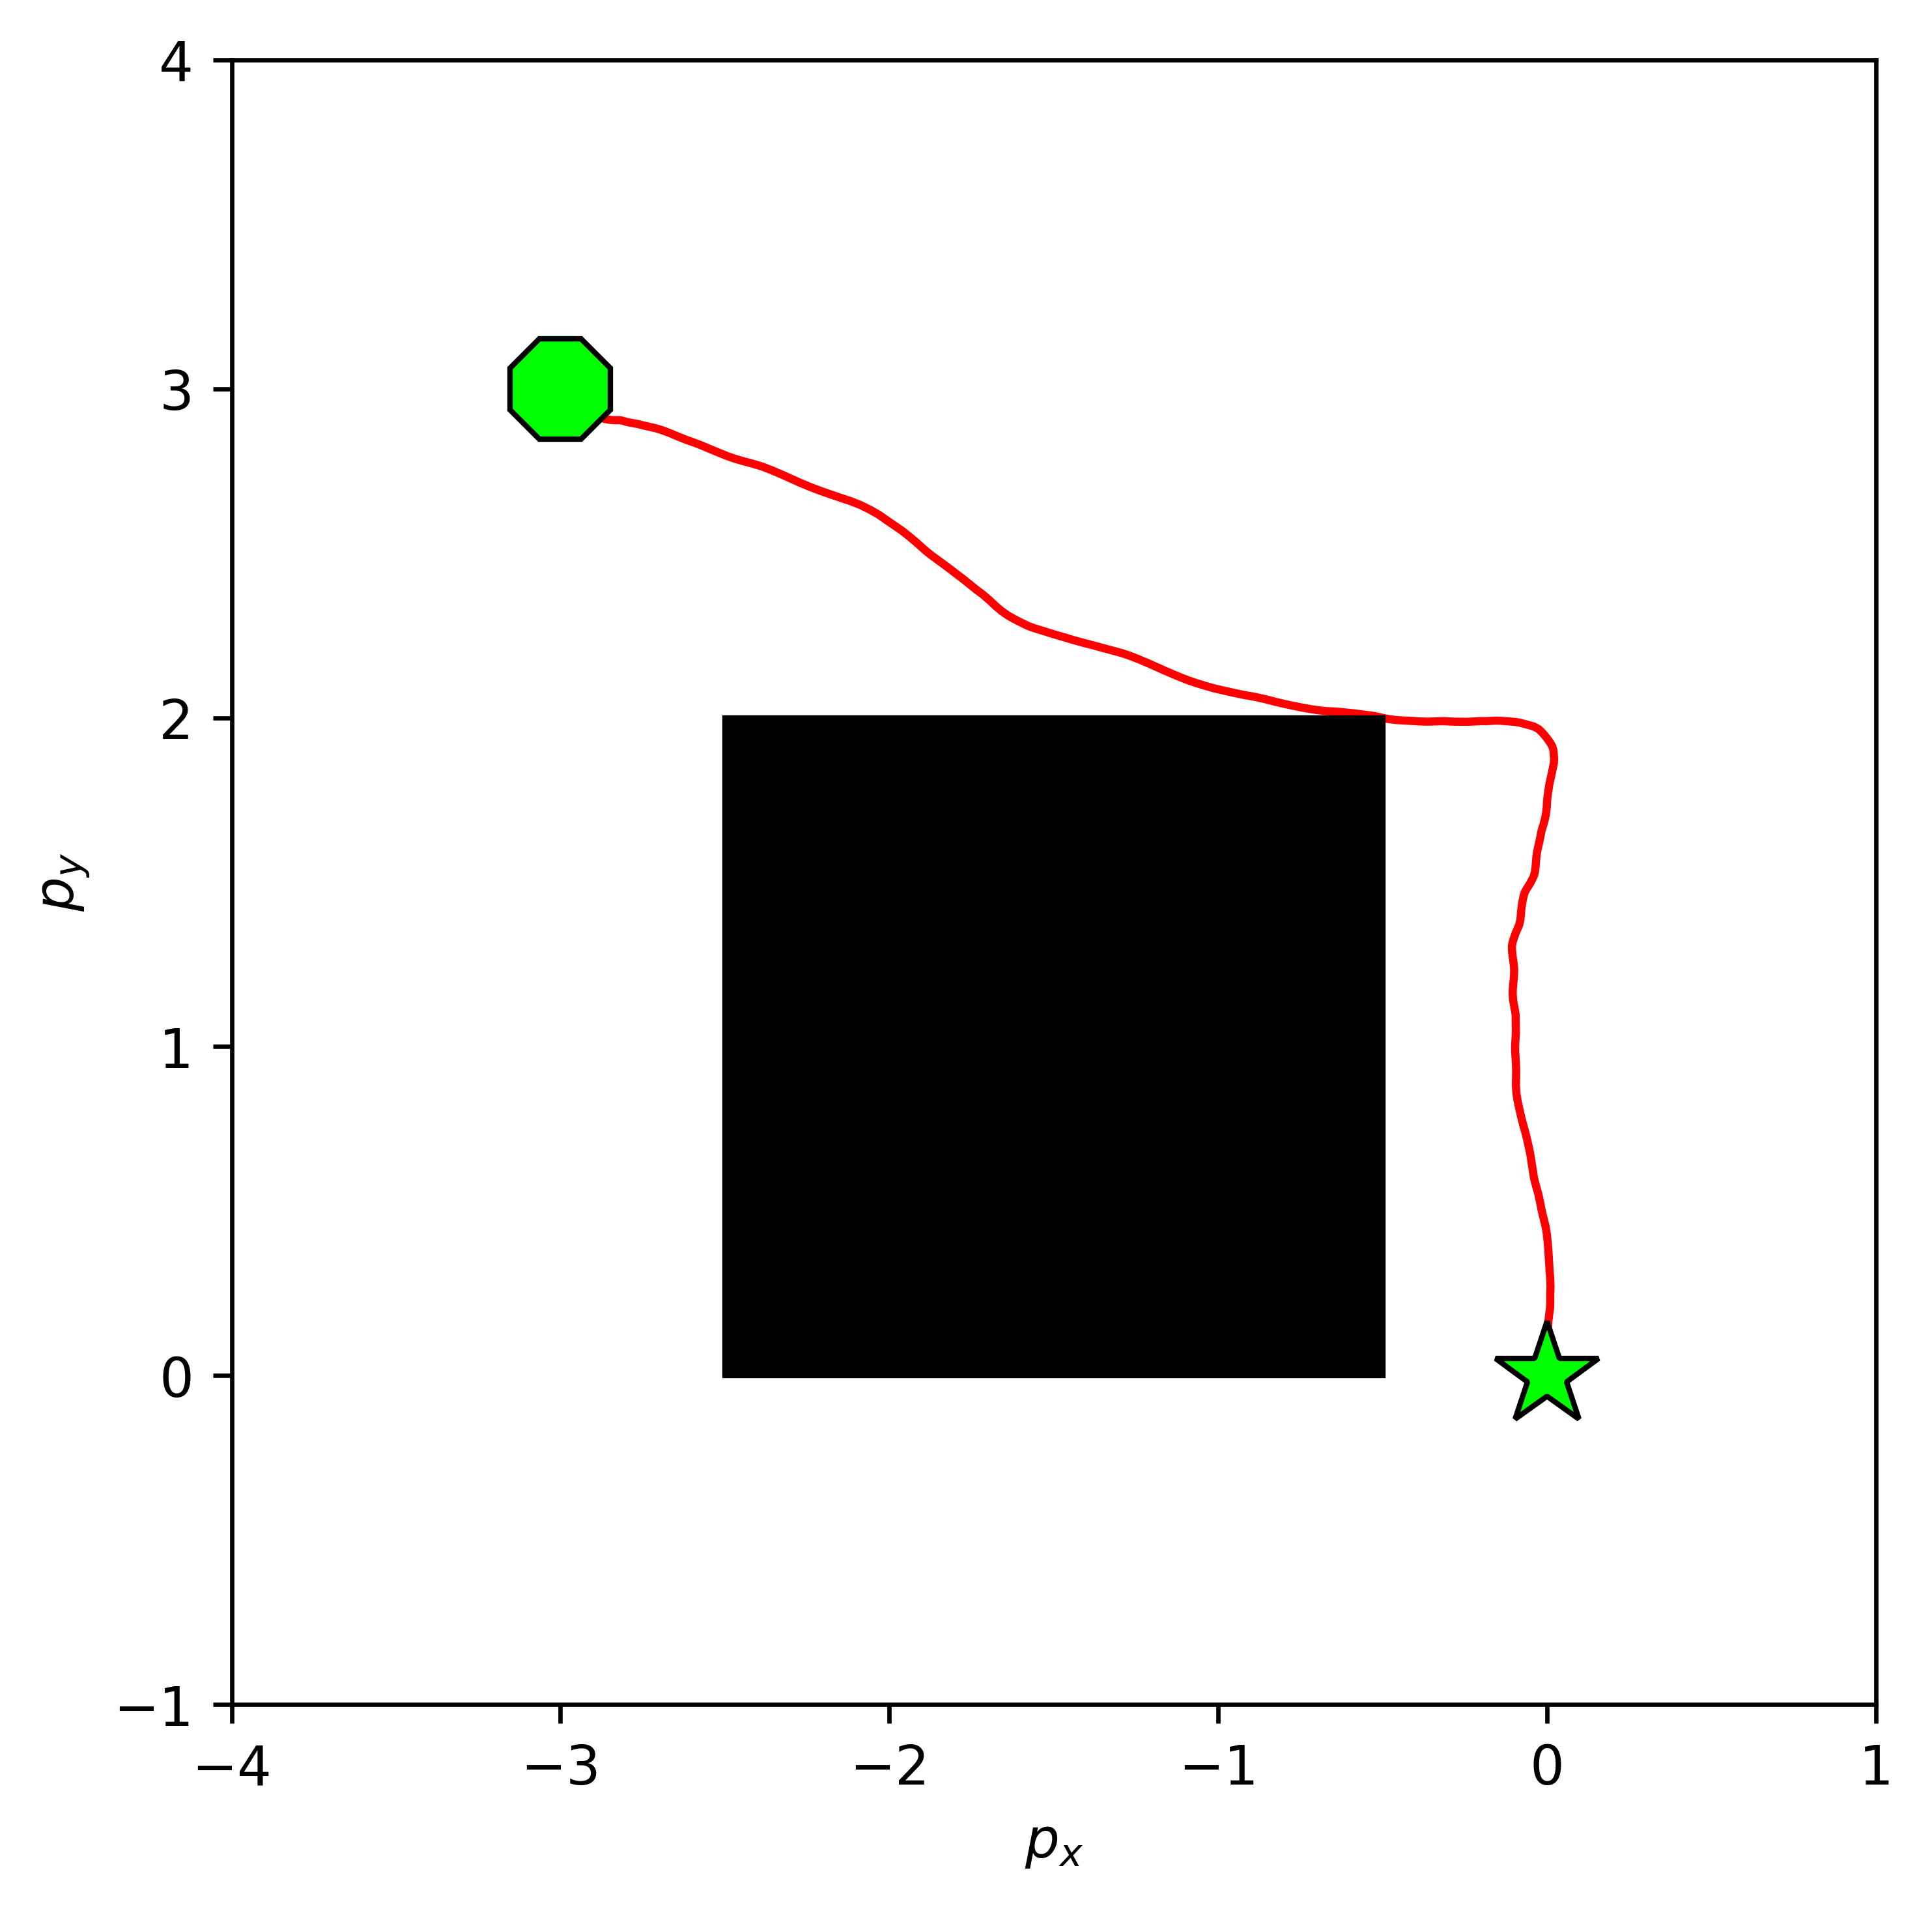

Goal reached at t=35.10s


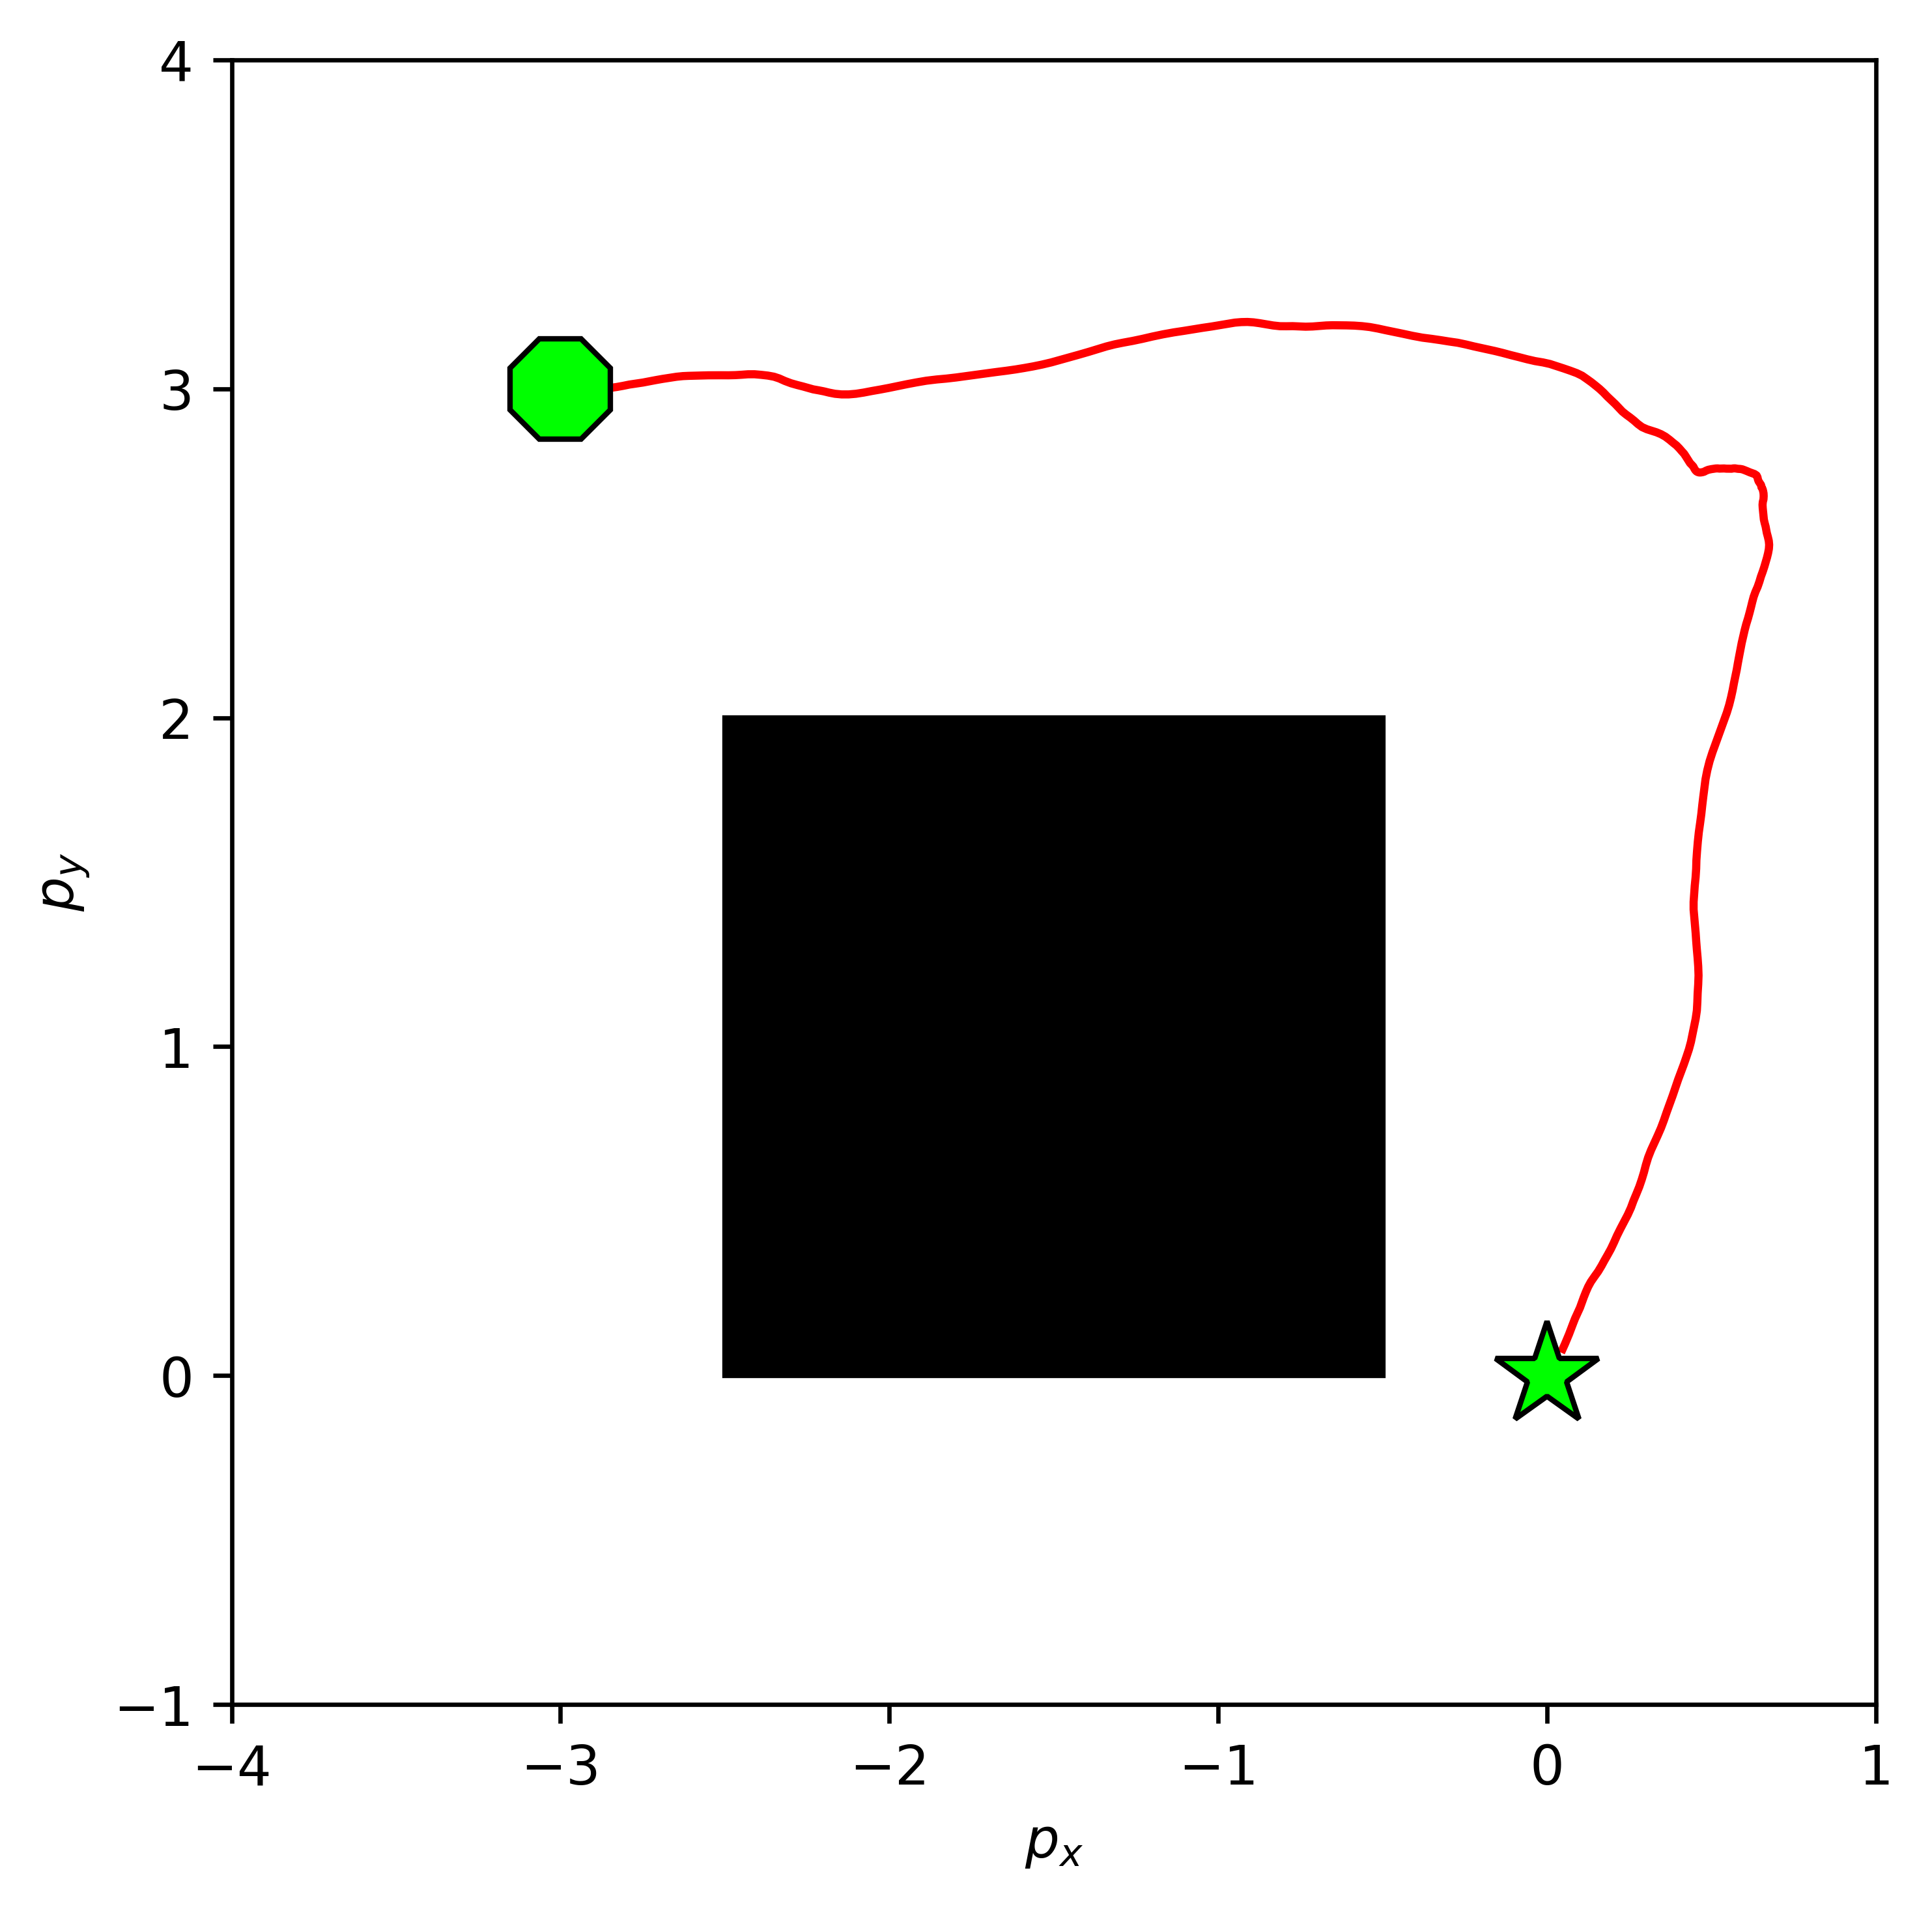

Goal reached at t=30.20s


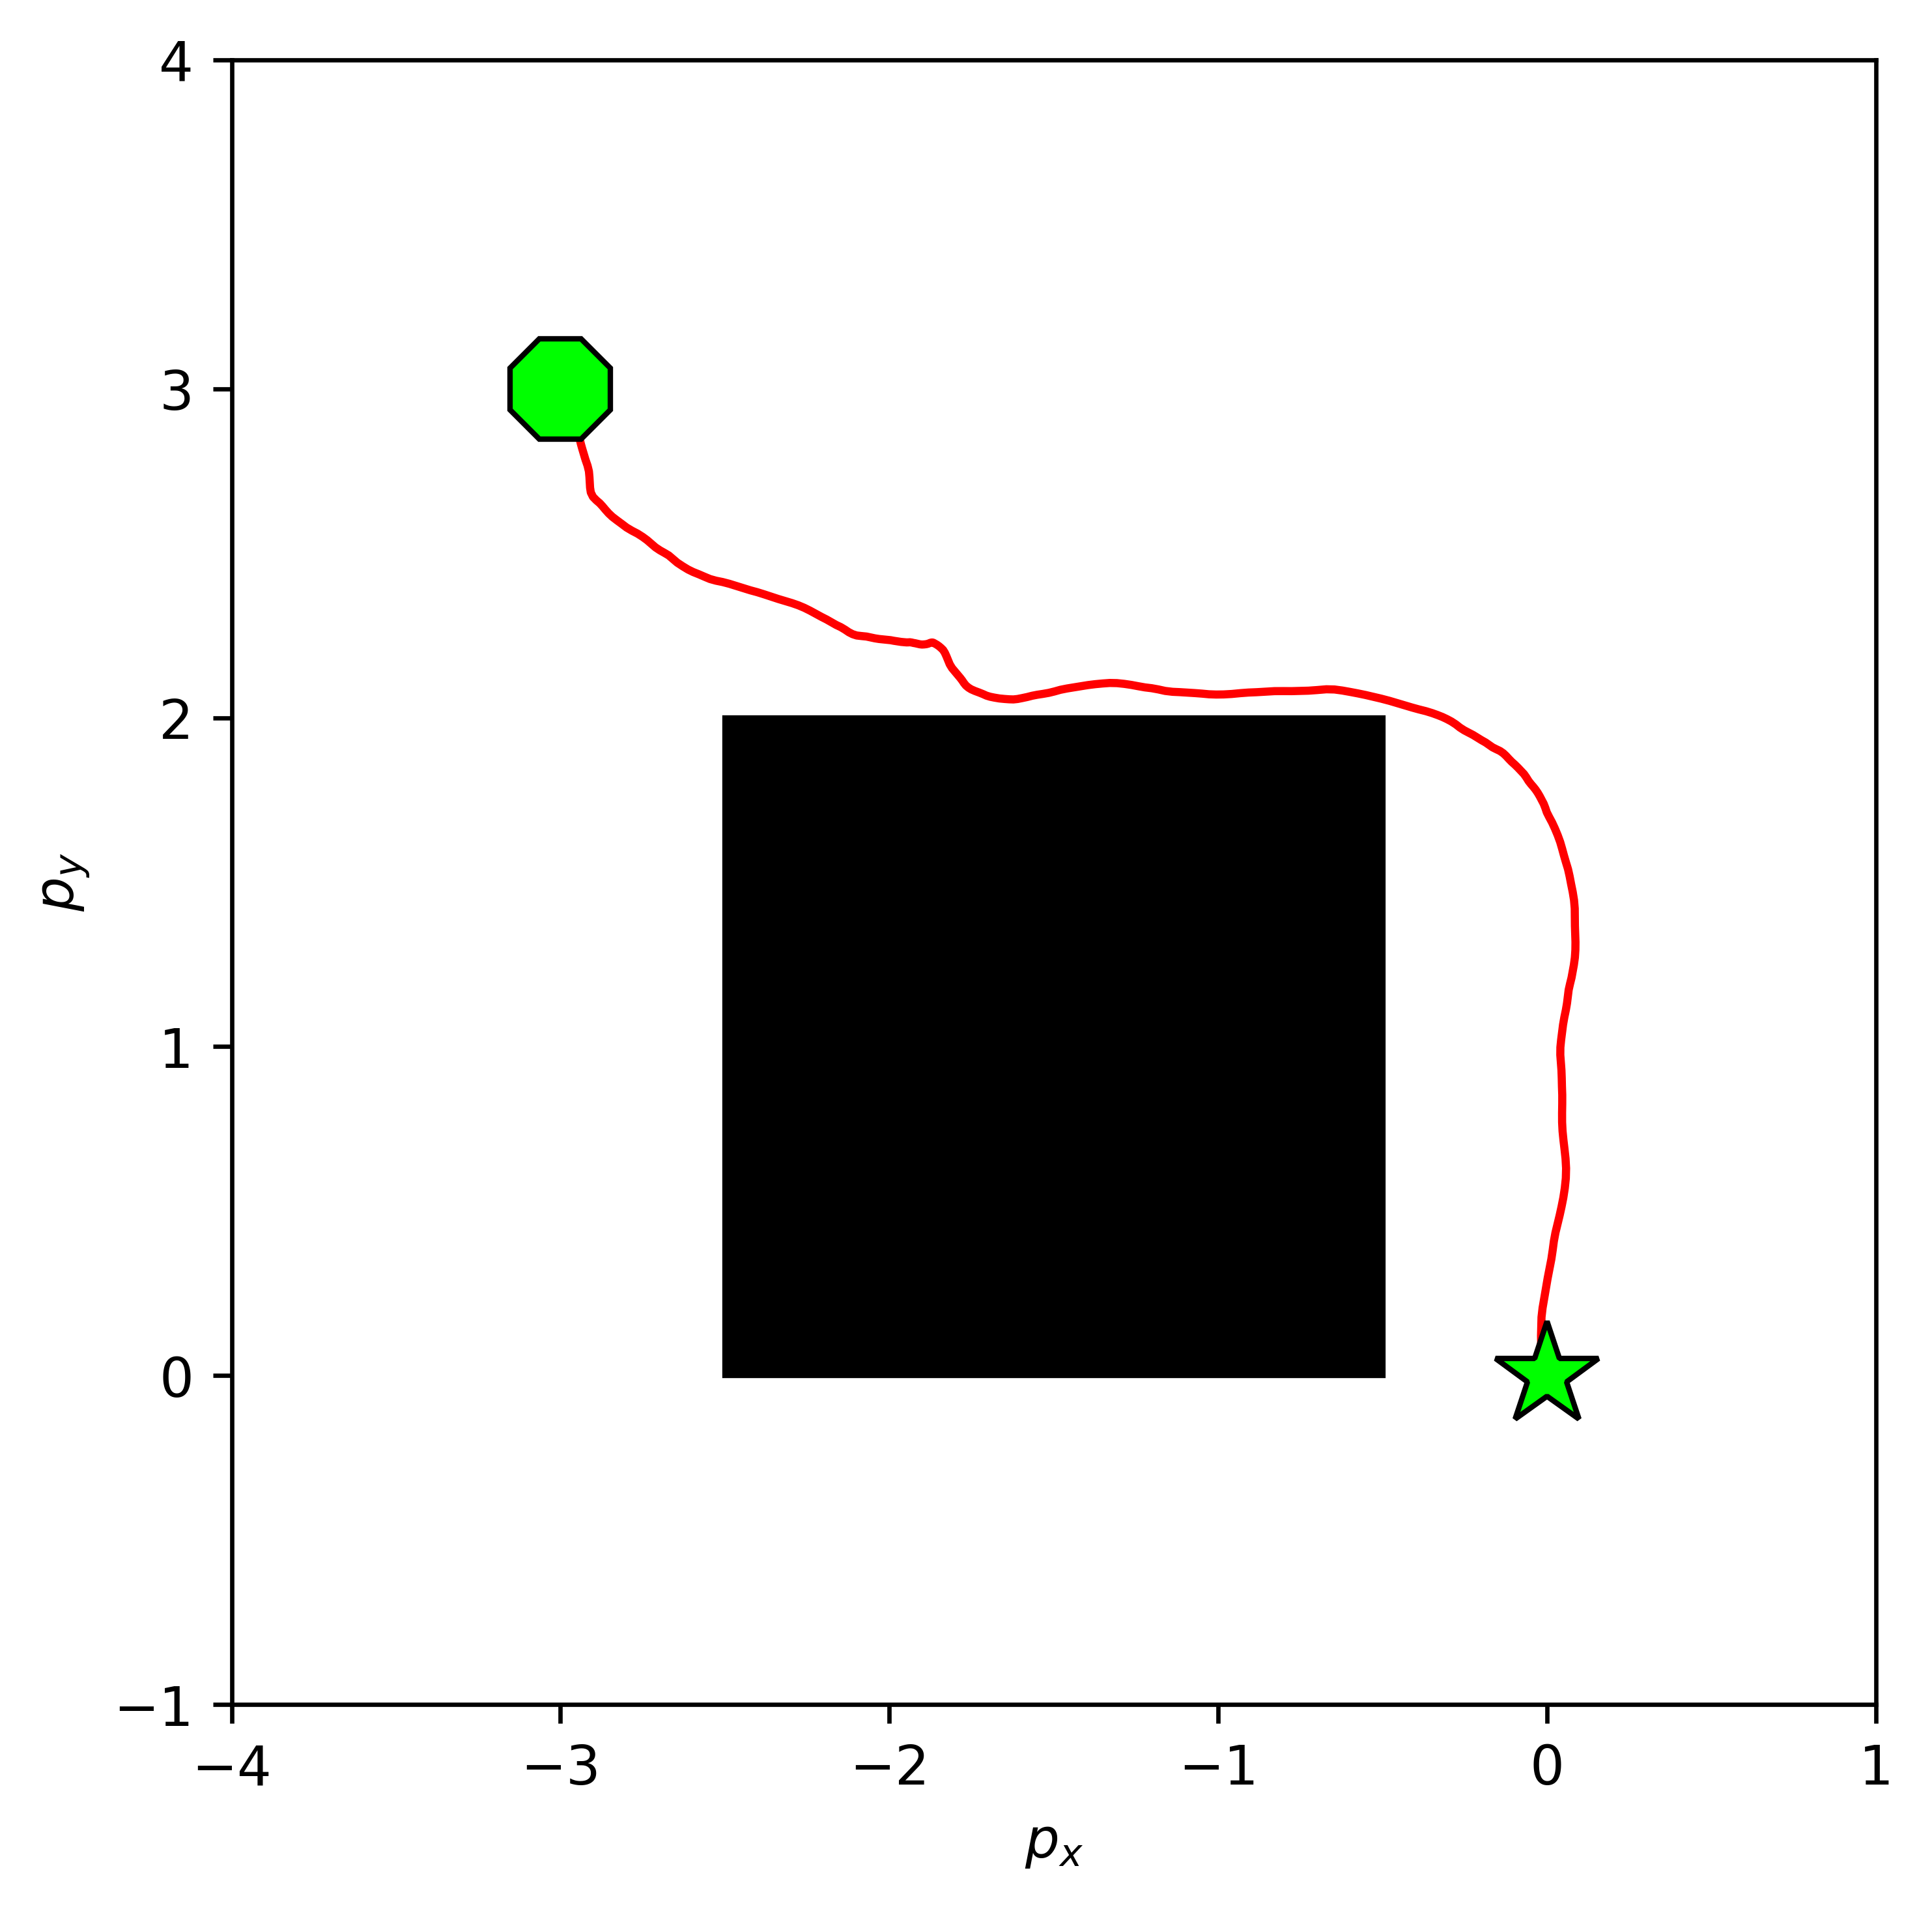

Goal reached at t=26.30s


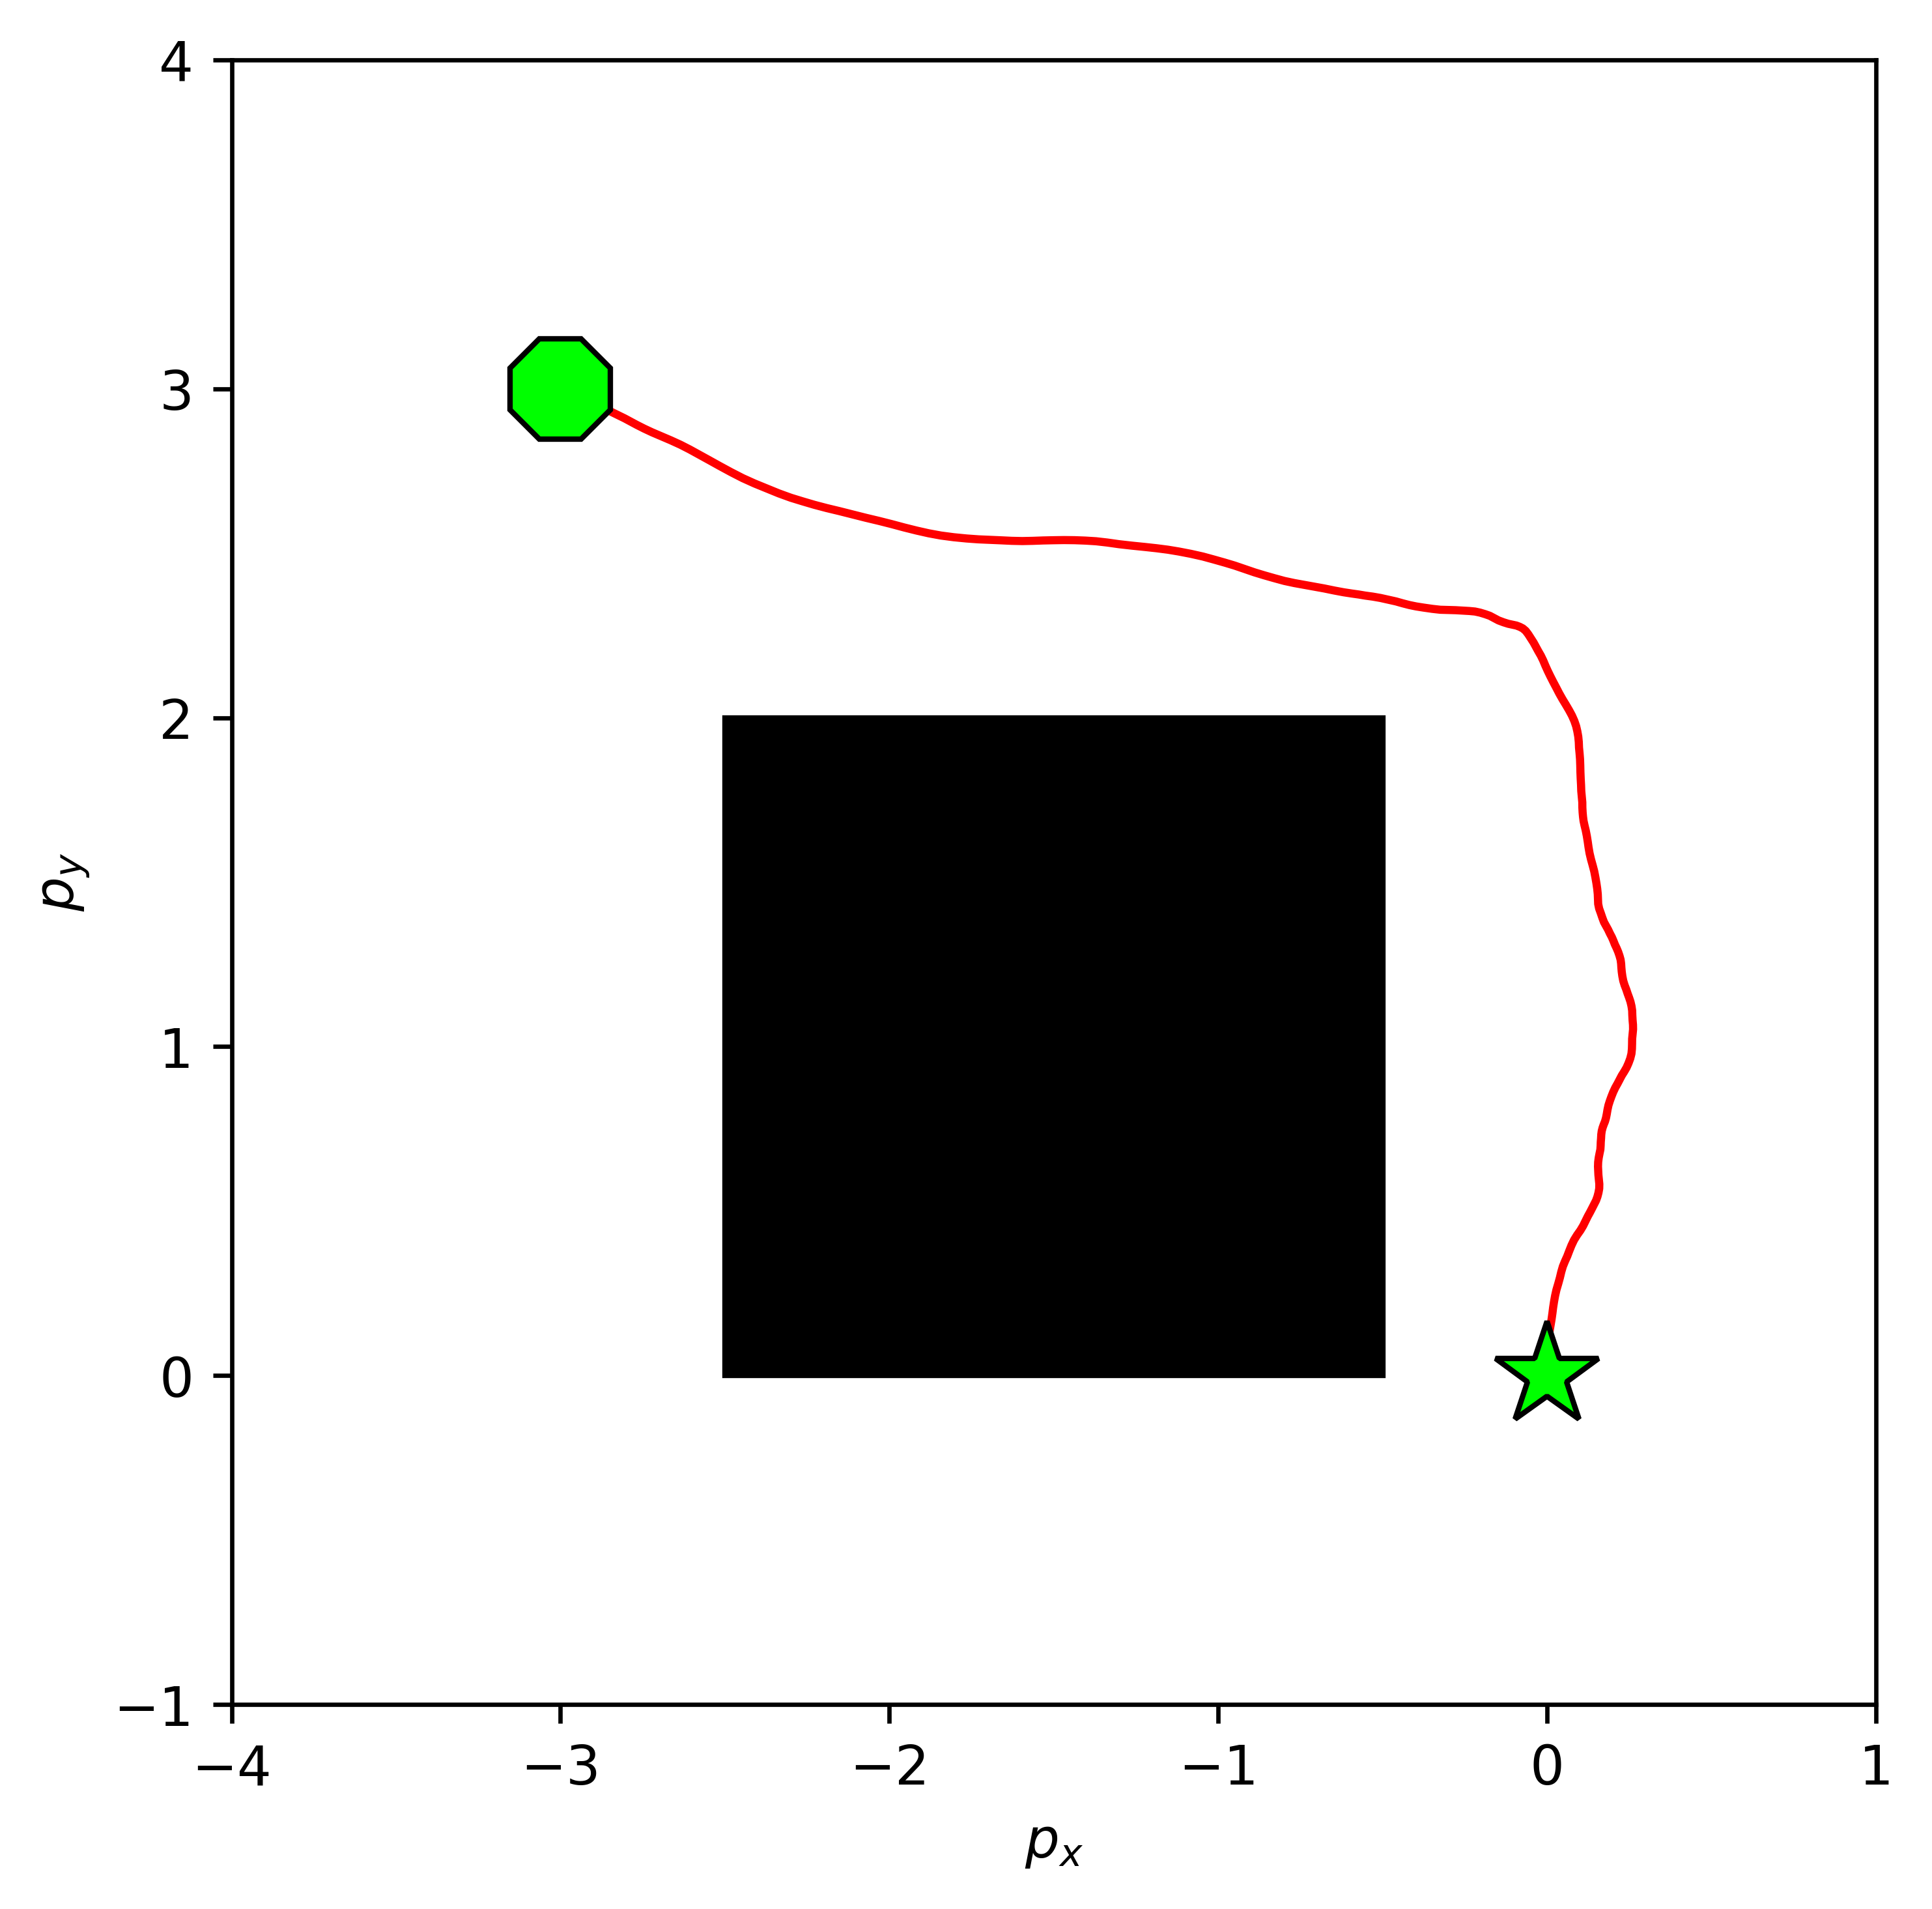

Goal reached at t=18.30s


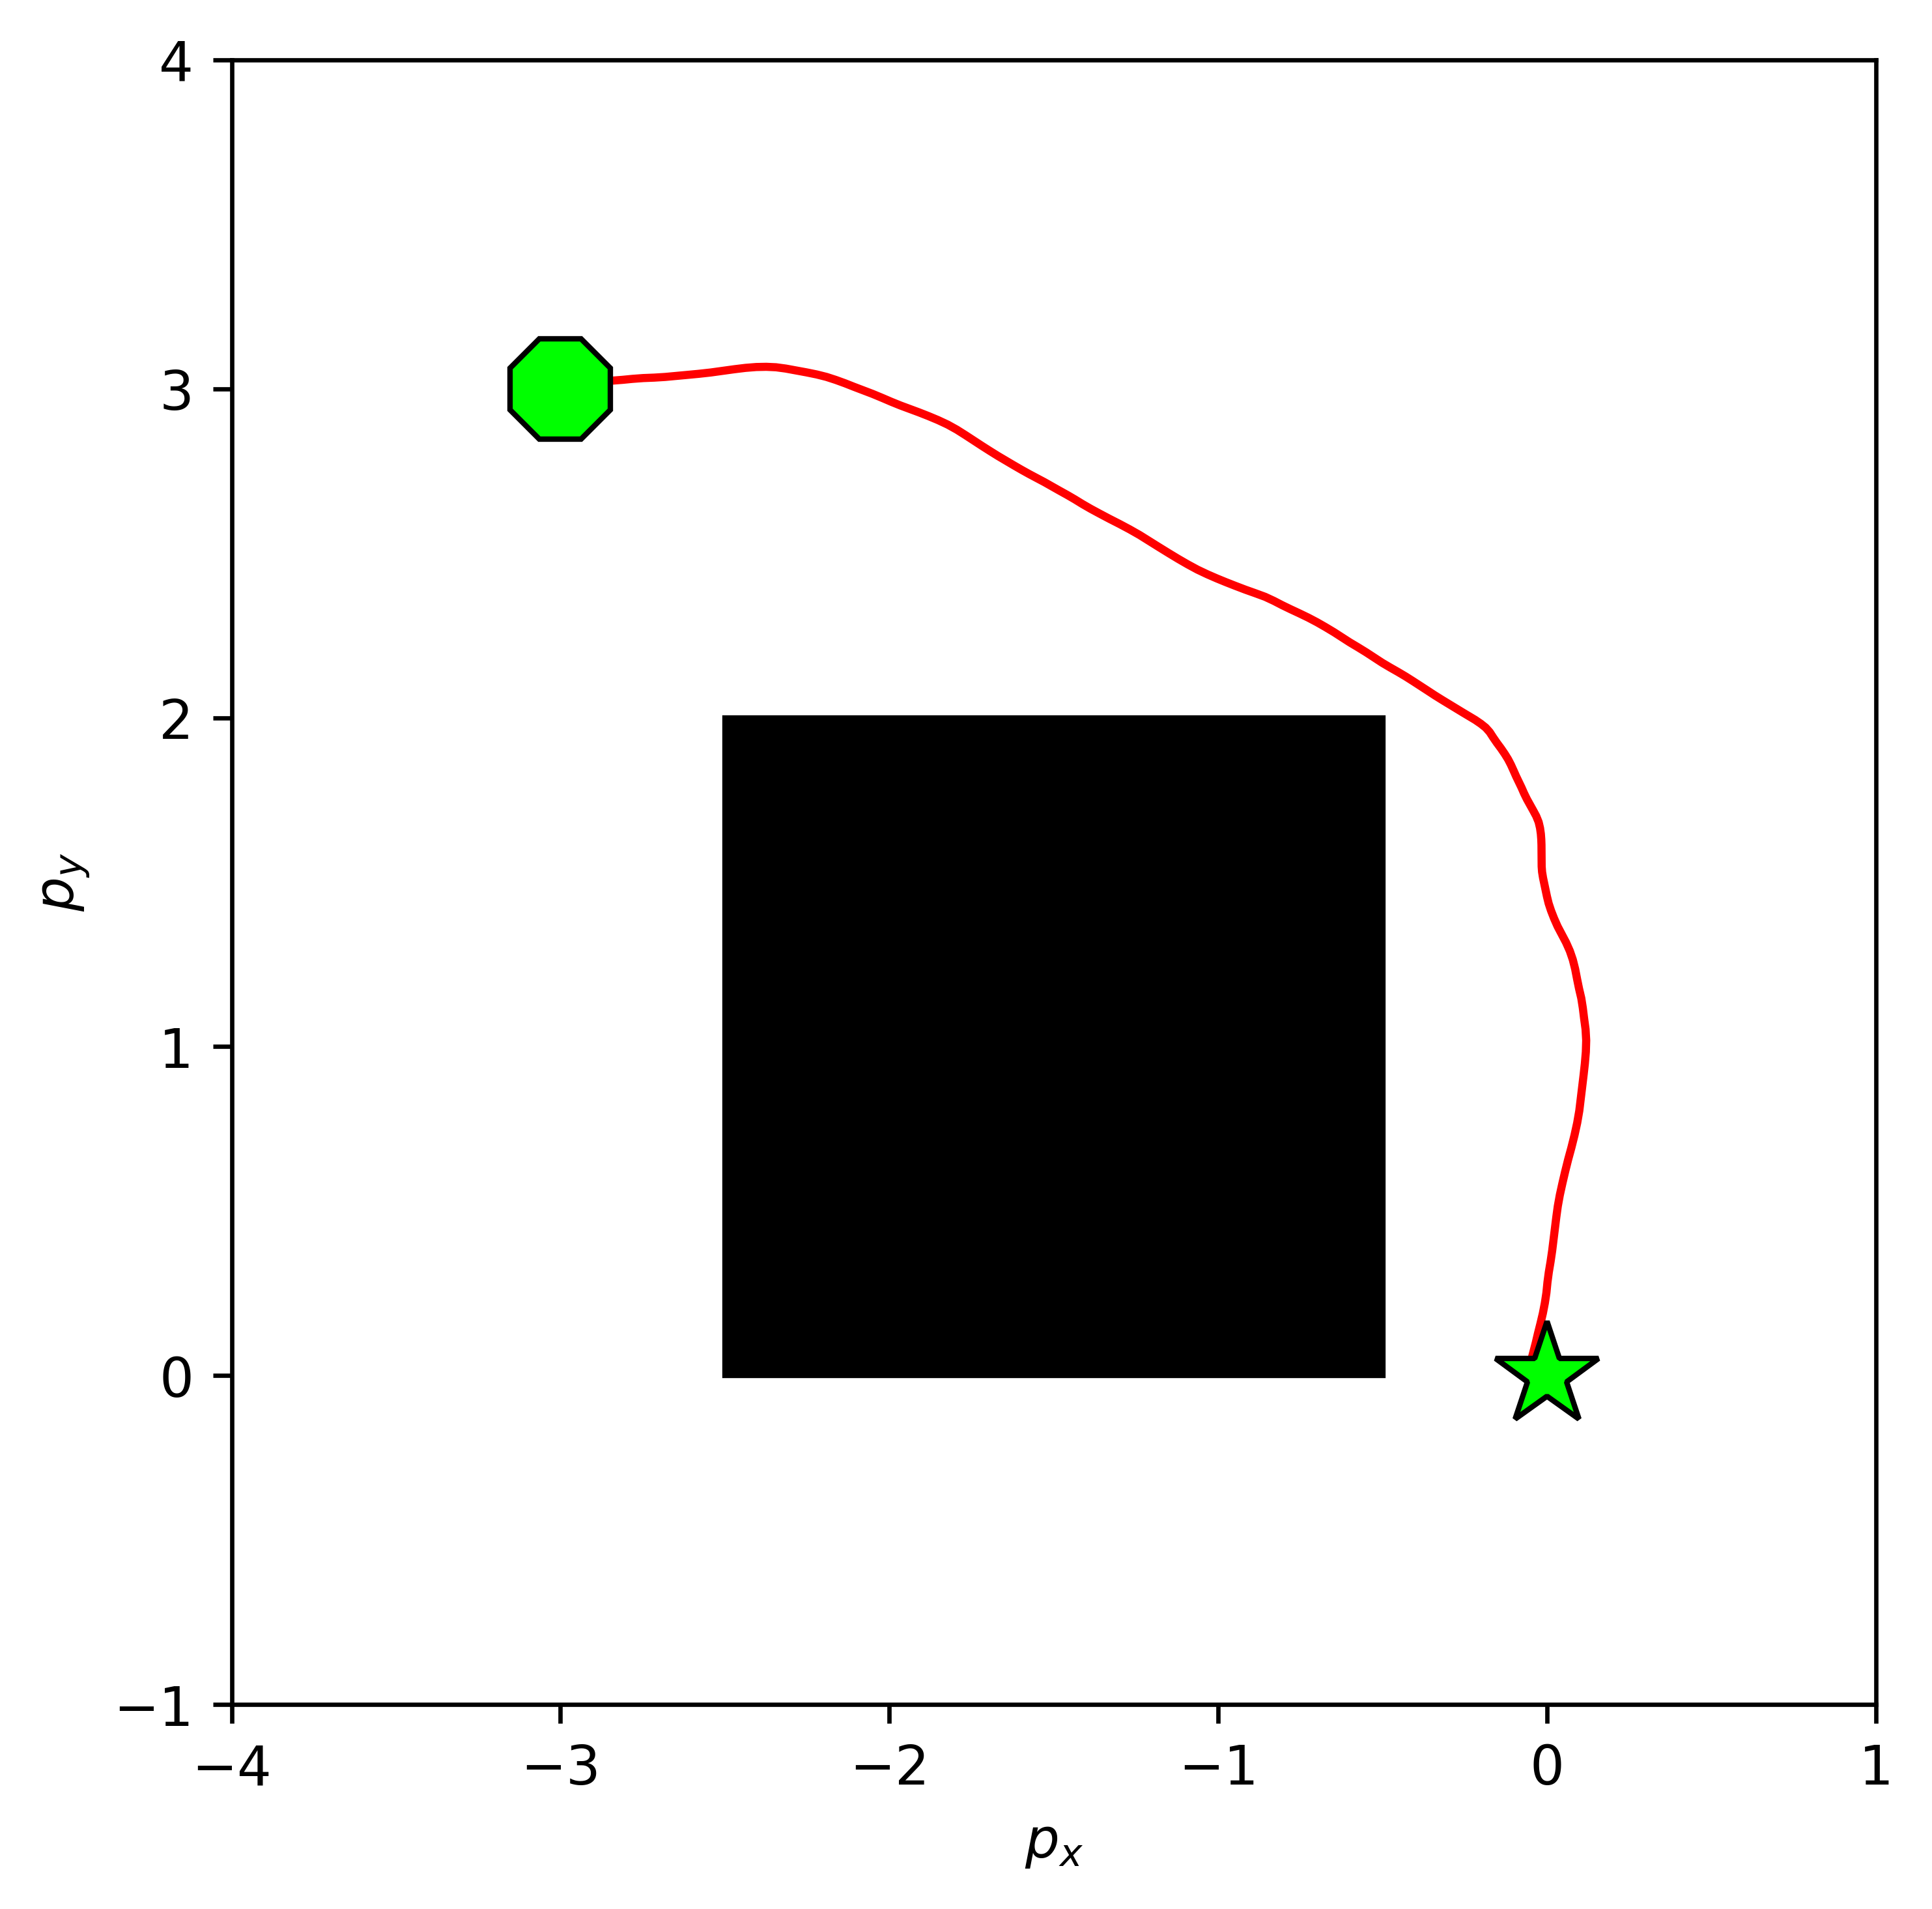

Goal reached at t=20.60s


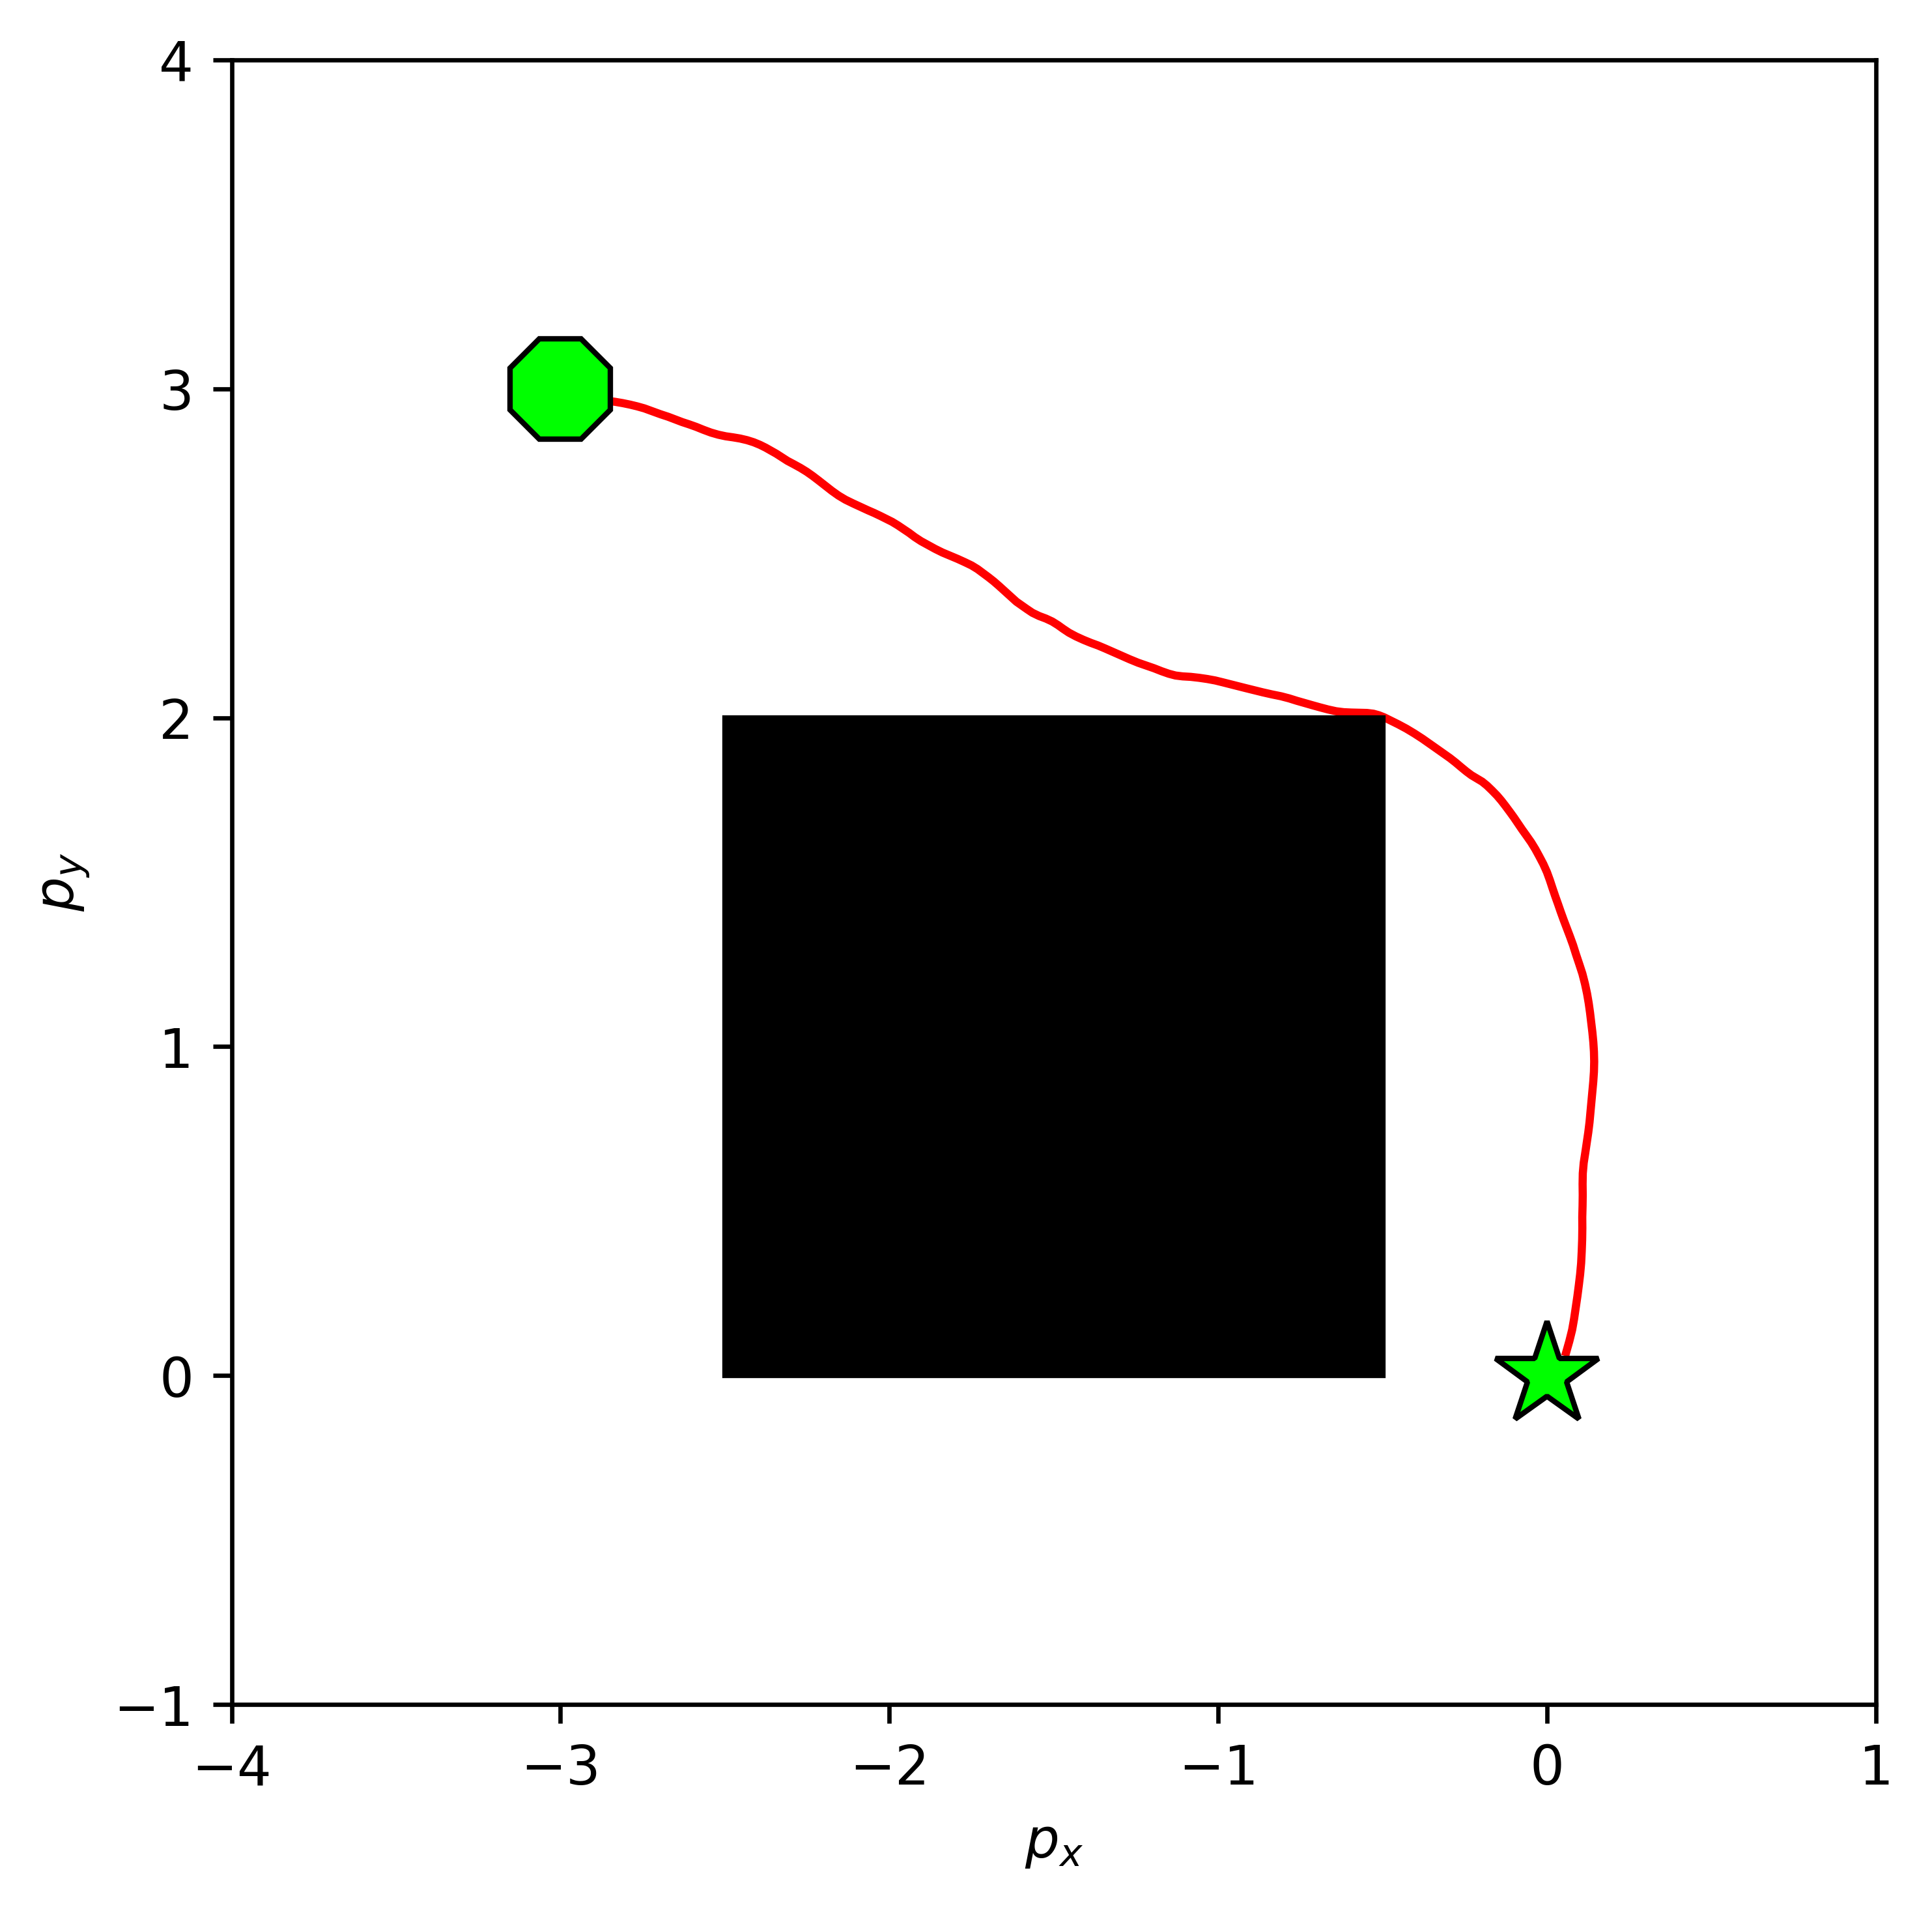

Hit obstacle


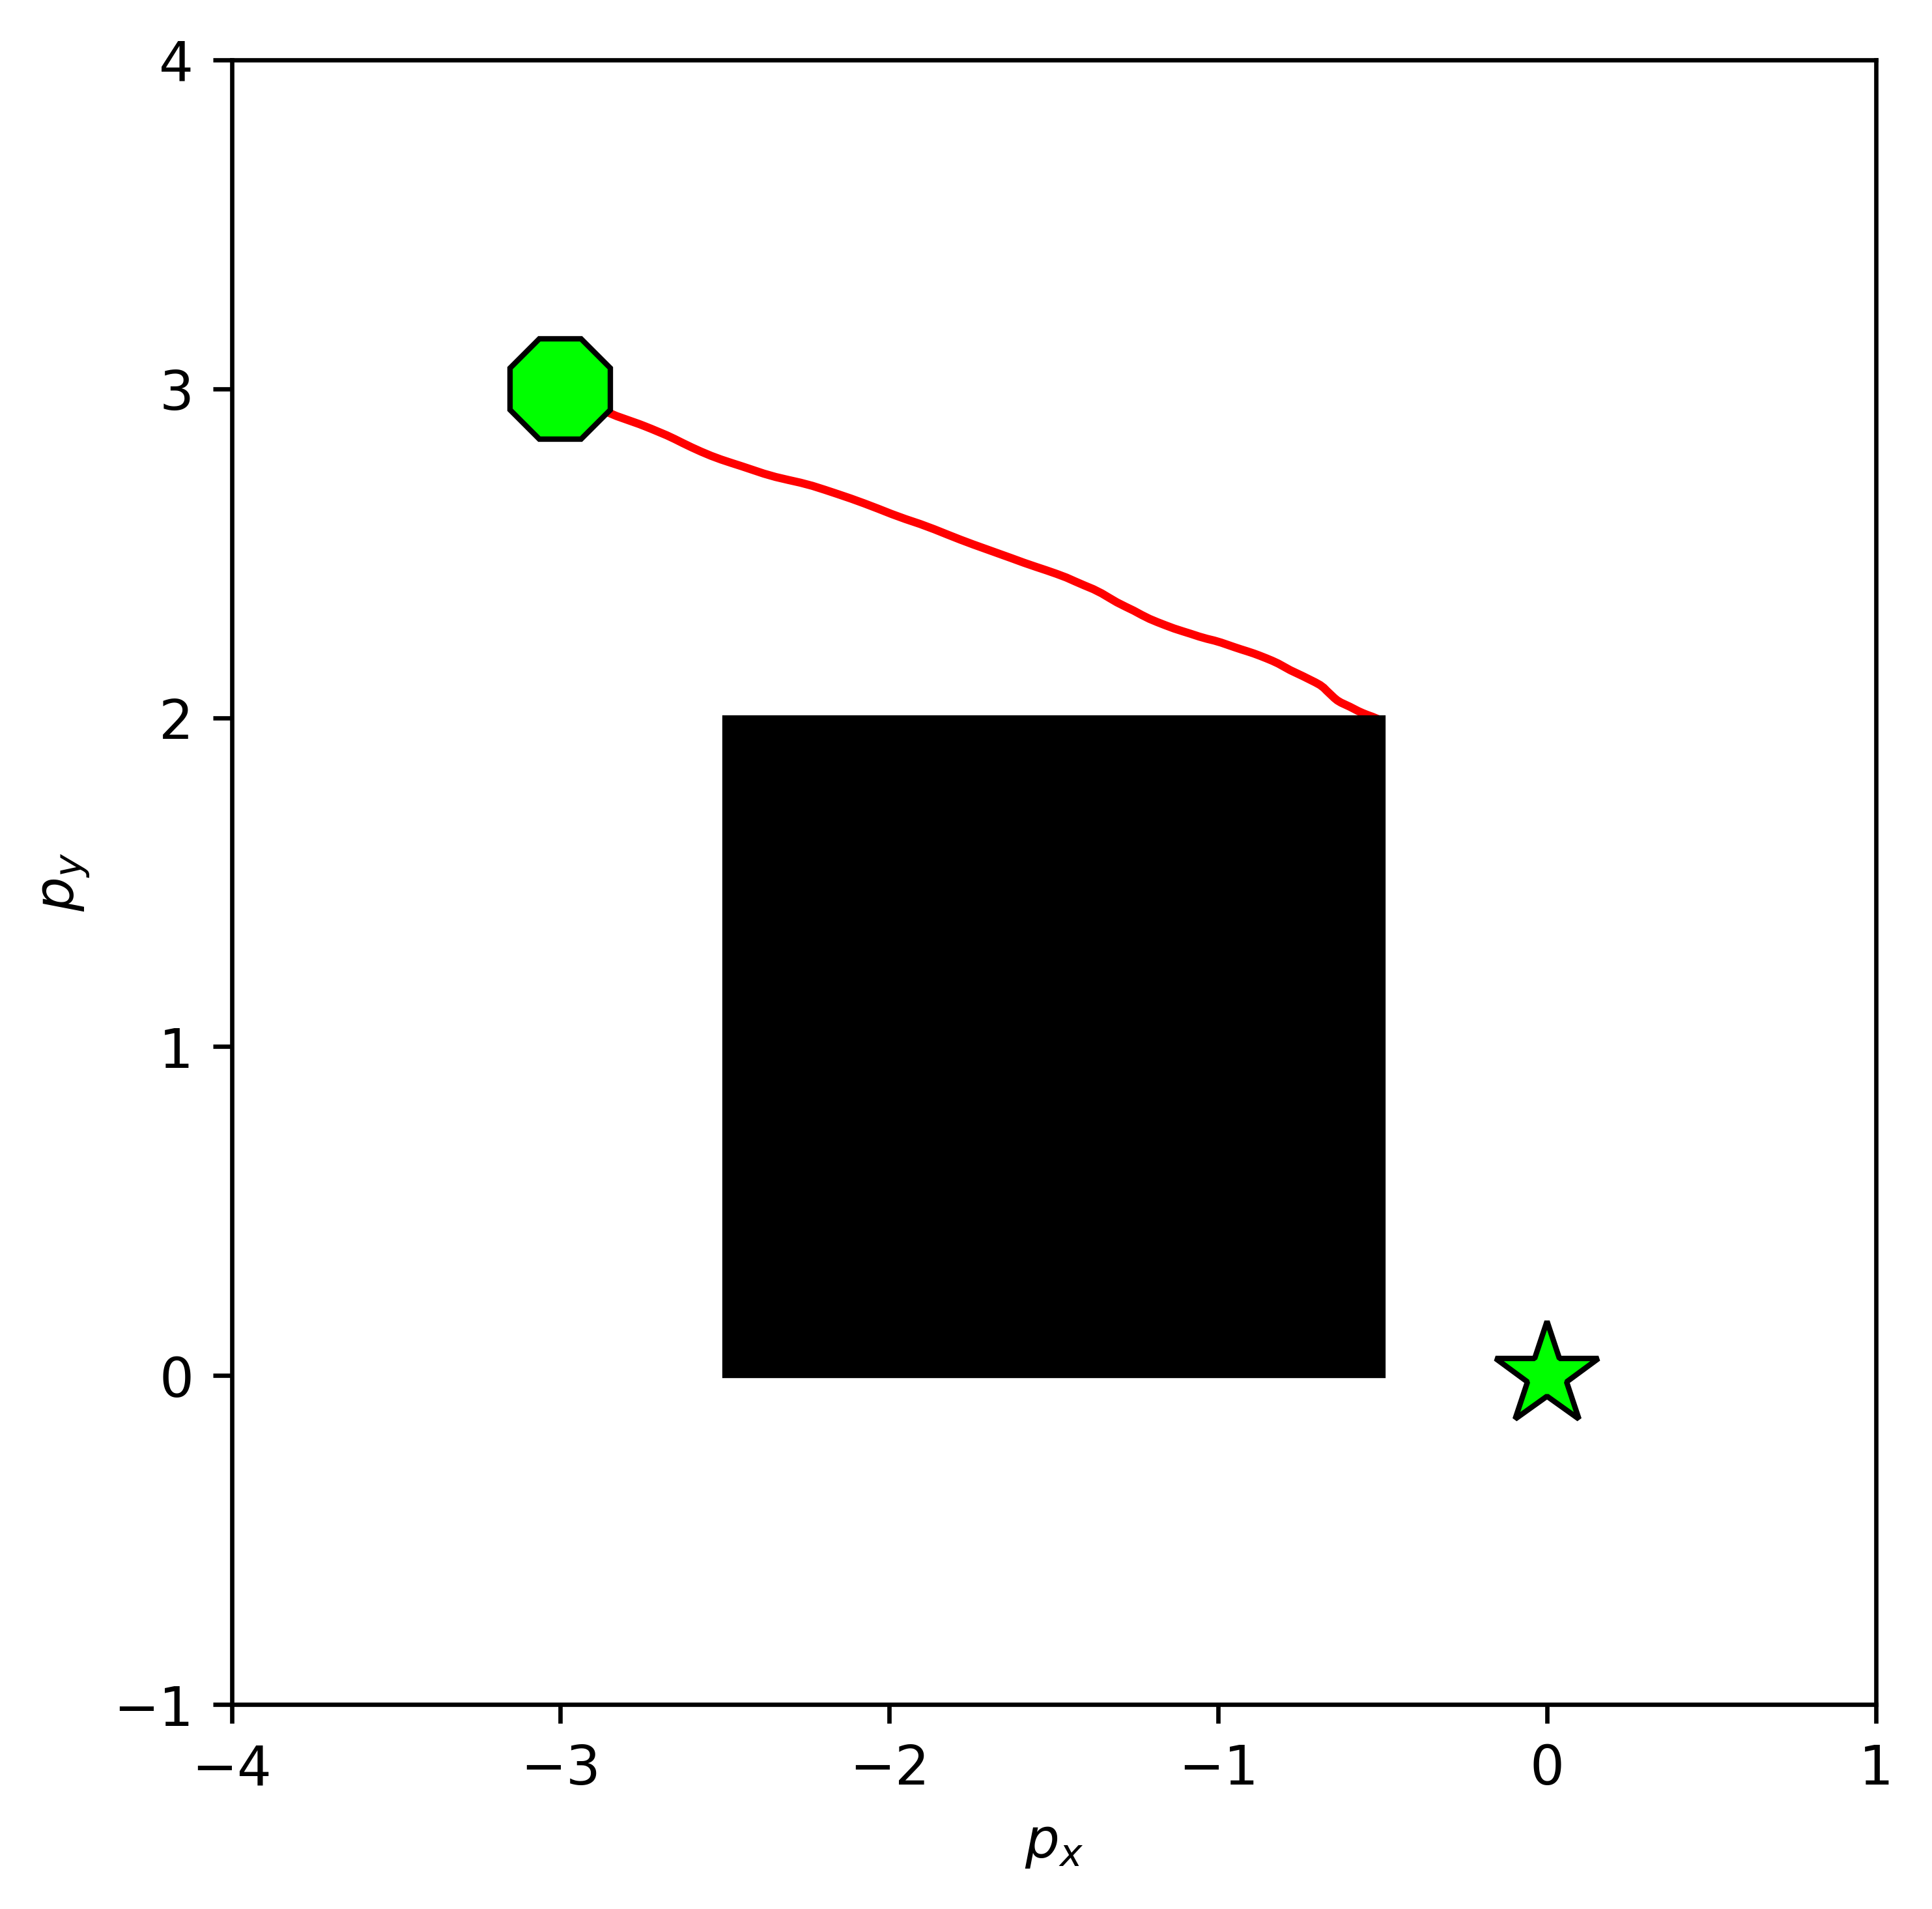

In [33]:
# Model parameters
for k in range(num_simulation) :
    terminate = False
    obstacle_positions = np.array([[-2.5, 0.0]])
    obstacle_radius = np.array([2.0])
    
    x_goal = np.array([0,0])
    x0 = np.array([-3.0, 3.0, 0, 0])
    
    # Nominal Error dist 
    n_data = 10
    errors = np.zeros( (n_data, 2) )*np.nan
    
    true_mus = [np.array([-0.1, 0]), np.array([0.1, 0])]
    true_covs = [ np.array([[0.01,0],[0,0.01]]), np.array([[0.01,0],[0,0.01]]) ]
    true_probs = np.array([0.5, 0.5])
    
    for n in range(n_data) :
        errors[n,:] = GMM(true_mus, true_covs, true_probs)
    # true_Sigma = np.array([[0.02, 0.0],
    #                        [0.0,   0.02]])
    # errors = np.random.multivariate_normal( np.zeros(2), true_Sigma, n_data)
    Sigma  = 1/(n_data-1) * (errors).T @ (errors)
    
    obs_cost = 1e3
    dist_weight = 0.01
    gamma = [300]
    T = 10.0
    dt = 0.1
    theta = 0.01
    goal_tolerance = 0.1
    num_trajs = 30
    
    # Simulation
    u_curr = np.zeros((int(T//dt), 2))
    x_hist = np.zeros( (max_steps+1, 4) )*np.nan
    u_hist = np.zeros( (max_steps+1, 2) )*np.nan
    x_hist[0] = x0
    
    vis_xlim = [-4.0, 1.0]
    vis_ylim = [-1.0, 4.0]
    
    
    hit_obstacle = False
    hit_boundary = False
    for t in range(max_steps) :
        u_curr, x_vis = path_integral(Sigma, x_hist[t], x_goal, u_curr, dist_weight, 
                               obs_cost, obstacle_positions, obstacle_radius, 
                               T, dt, theta, num_trajs, init_report=t, gammas=gamma)
        u_hist[t] = u_curr[0]
        
        # Simulate stochastic dynamics under control channel noise
        # u_noise = np.random.multivariate_normal(np.zeros(2), true_Sigma)
        u_noise = GMM(true_mus, true_covs, true_probs)
        
        # true mu, no u_noise arrow noise
        x_hist[t+1] =np.array([[1, 0, dt, 0],
                               [0, 1, 0, dt],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1]]) @ x_hist[t] + np.array([[(dt**2)/2, 0],[0, (dt**2)/2],[dt, 0],[0, dt]]) @ (u_curr[0] + u_noise)    
        
        
        for obs_pos, obs_r in zip(obstacle_positions, obstacle_radius) :
            if (x_hist[t+1,0] > obs_pos[0] and x_hist[t+1,0] < obs_pos[0] + obs_r and 
                x_hist[t+1,1] > obs_pos[1] and x_hist[t+1,1] < obs_pos[1] + obs_r) :
                
                hit_obstacle = True
                terminate = True
                fail_index.append(k)
                print("Hit obstacle")
        
        if hit_obstacle == True :
            break
        
        # Boundary 
        if (x_hist[t+1,0] < -4 or x_hist[t+1,0] > 1  or x_hist[t+1,1] < -1 or x_hist[t+1,1] > 4 )  :
            hit_boundary = True
            terminate = True
            fail_index.append(k)
            print("Hit boundary")
            
        
        if hit_boundary == True :
            break
        
        # Goal check
        if np.linalg.norm(x_hist[t+1, :2] - x_goal) <= goal_tolerance :
            print("Goal reached at t={:.2f}s".format(t*dt))
            success_time.append(t*dt)
            terminate = True
            success_index.append(k)
            break
    
    x_hists[k, :t, :] = x_hist[:t, :2]

    if terminate == True:
        # Visualize the basic setup
        fig, ax = plt.subplots()
        ax.plot([x0[0]], [x0[1]], '8', markersize = 20, markerfacecolor = 'lime', label = 'Initial State',markeredgecolor = 'k', zorder=6  )
        ax.plot([x_goal[0]], [x_goal[1]], '*', markersize = 20, markerfacecolor = 'lime', label = 'Target State',markeredgecolor = 'k', zorder=6  )
        
        # Show obstacles
        for obs_pos, obs_r in zip(obstacle_positions, obstacle_radius) :
            obs = plt.Rectangle(obs_pos, obs_r, obs_r, color='k', fill=True, zorder=6)
            ax.add_patch(obs)
        
        # Track the realized trajectoy
        ax.plot(x_hist[:,0], x_hist[:,1], 'r', label='Past state')
        # ax.plot(x_vis[:,:,0].T, x_vis[:,:,1].T, 'k', alpha=0.1, zorder=3)
        
        ax.set_xlim(vis_xlim)
        ax.set_ylim(vis_ylim)
        
        # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
        #   fancybox=True, shadow=True, ncol=5)
        ax.set_aspect('equal')
        plt.tight_layout()
        ax.set_xlabel(r'$p_{x}$')
        ax.set_ylabel(r'$p_{y}$')
        plt.gcf().set_dpi(600)
        plt.show()

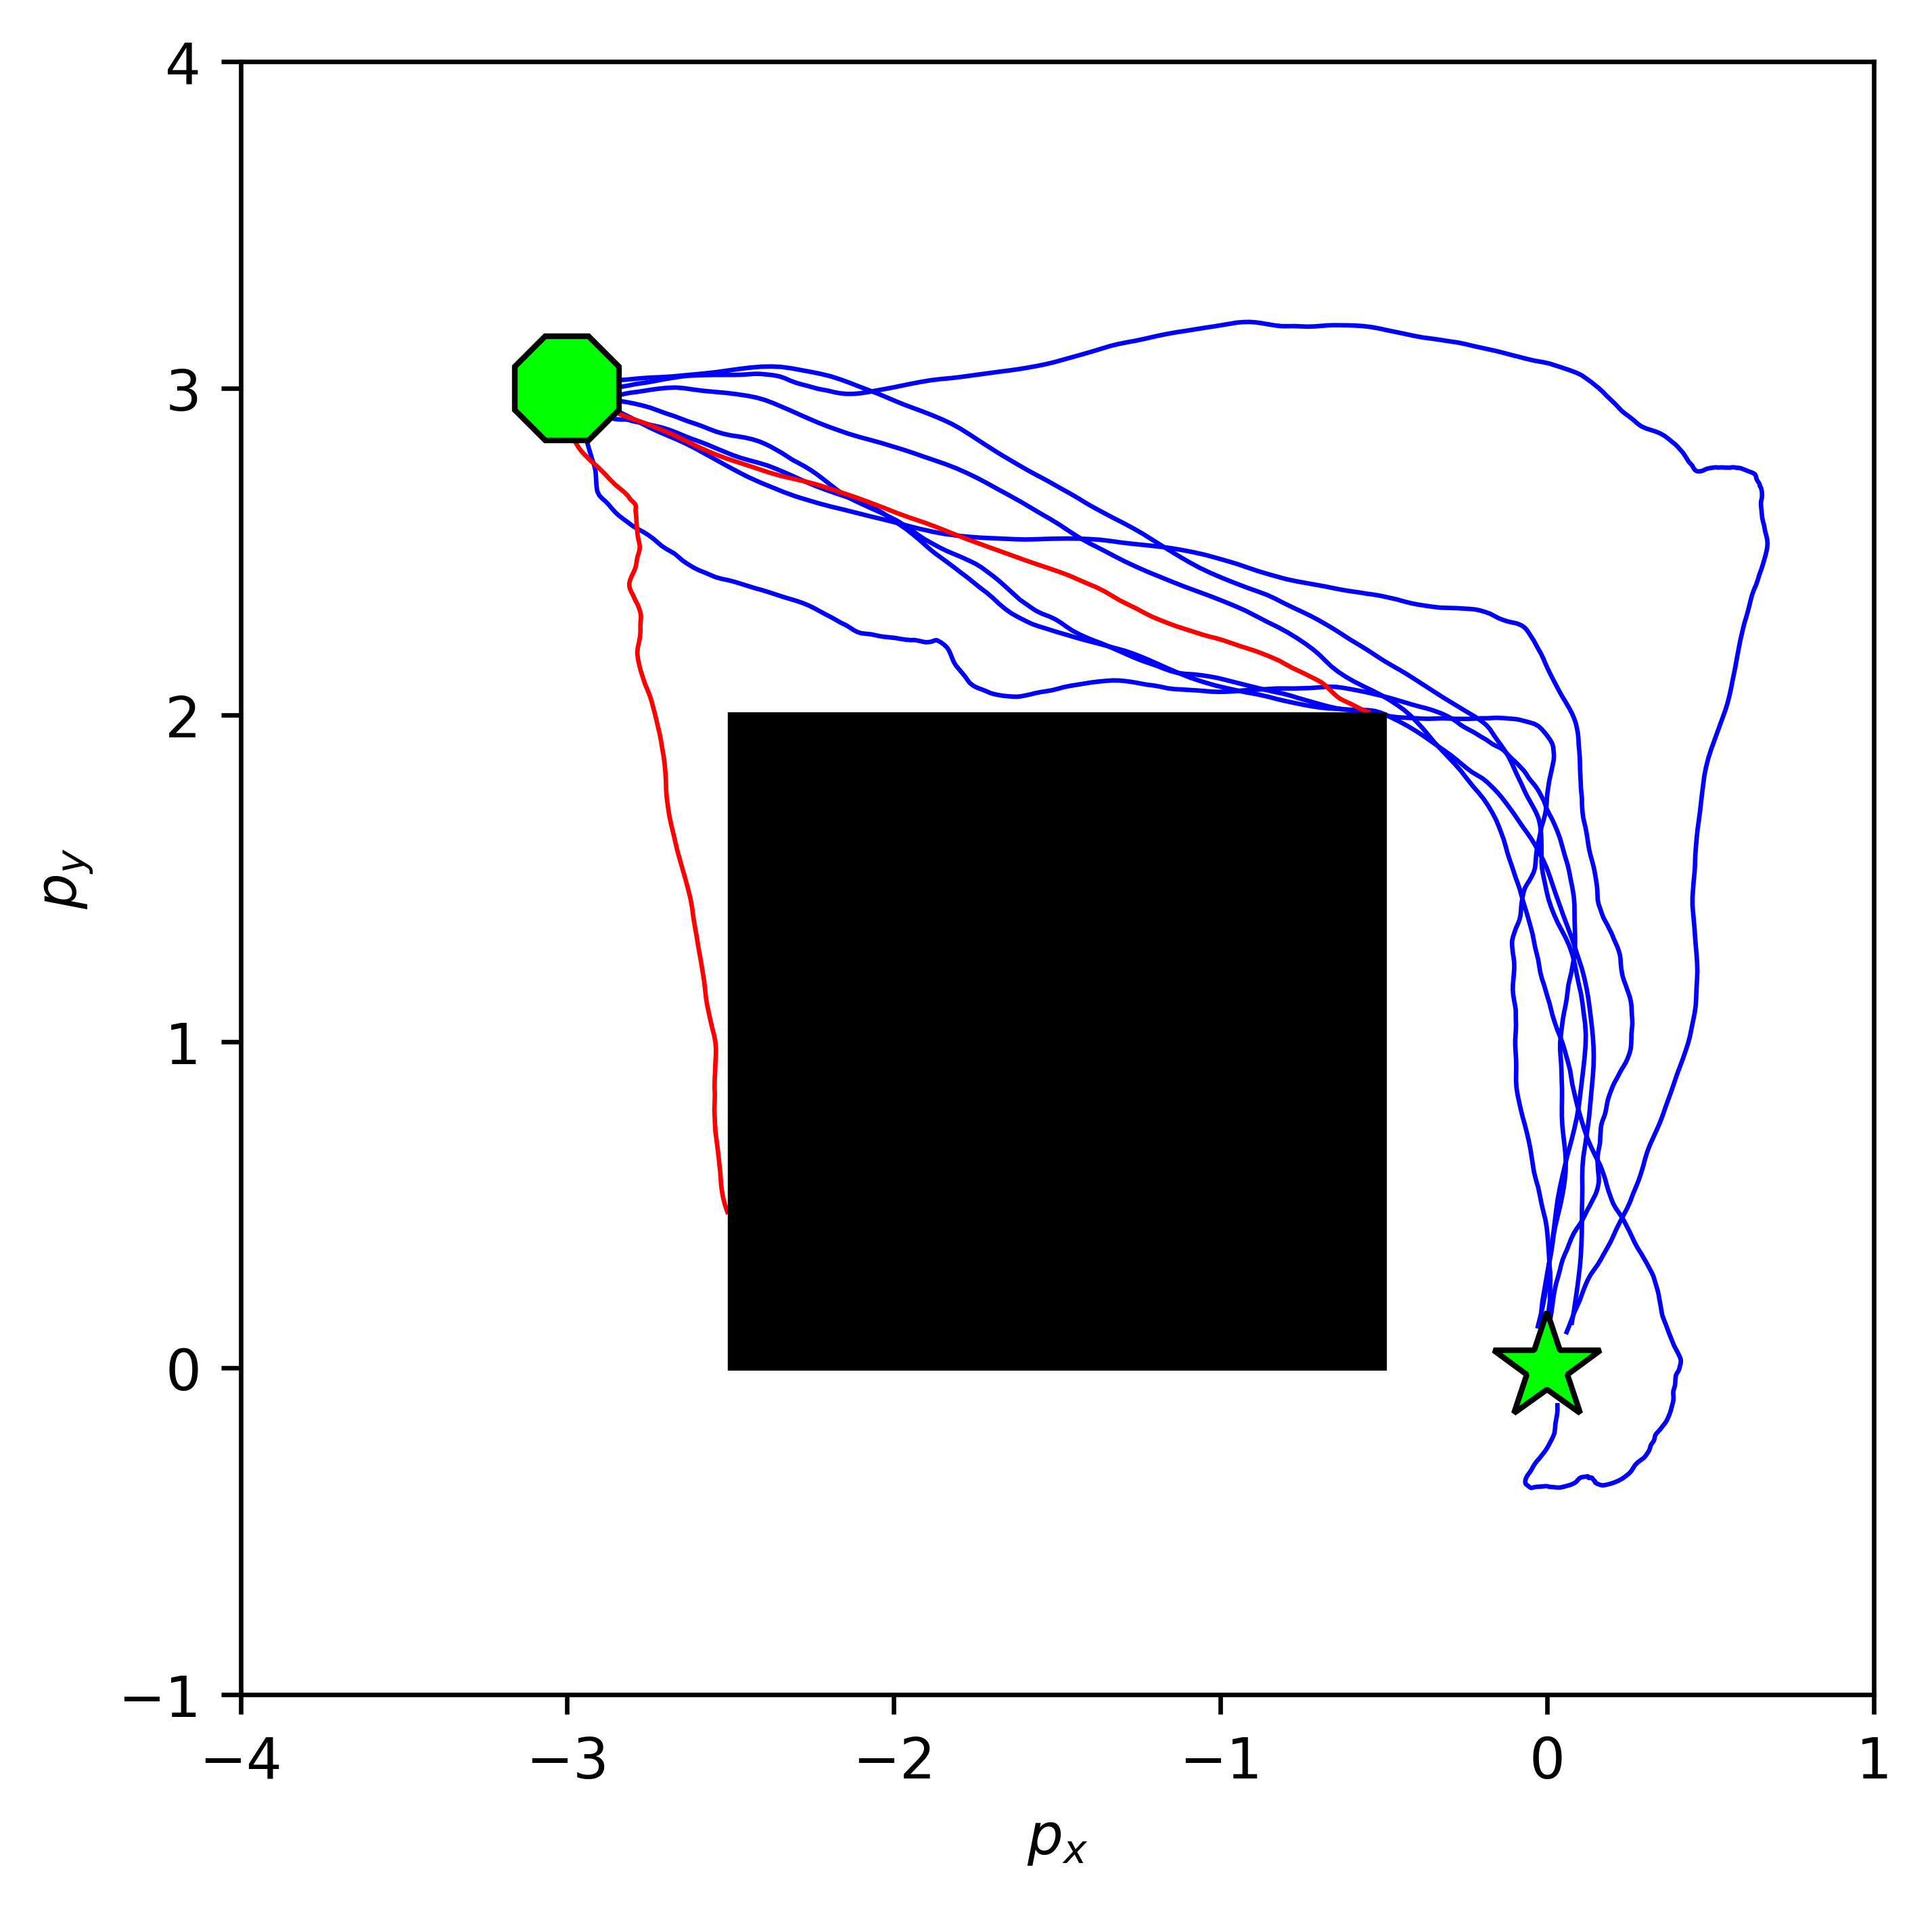

In [34]:
'''
Visualizes the results by plotting the initial and goal states, obstacles, and the realized trajectories.
'''

# Visualize the basic setup
fig, ax = plt.subplots()
ax.plot([x0[0]], [x0[1]], '8', markersize = 20, markerfacecolor = 'lime', label = 'Initial State',markeredgecolor = 'k', zorder=6  )
ax.plot([x_goal[0]], [x_goal[1]], '*', markersize = 20, markerfacecolor = 'lime', label = 'Target State',markeredgecolor = 'k', zorder=6  )

# Show obstacles
for obs_pos, obs_r in zip(obstacle_positions, obstacle_radius) :
    obs = plt.Rectangle(obs_pos, obs_r, obs_r, color='k', fill=True, zorder=6)
    ax.add_patch(obs)

# Track the realized trajectoy
ax.plot(x_hists[success_index,:,0].T, x_hists[success_index,:,1].T, 'b', linewidth=0.8)
ax.plot(x_hists[fail_index,:,0].T, x_hists[fail_index,:,1].T, 'r', linewidth=0.8)
# ax.plot(x_vis[:,:,0].T, x_vis[:,:,1].T, 'k', alpha=0.1, zorder=3)

ax.set_xlim(vis_xlim)
ax.set_ylim(vis_ylim)
ax.set_xlabel(r'$p_{x}$')
ax.set_ylabel(r'$p_{y}$')
plt.gcf().set_dpi(600)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#   fancybox=True, shadow=True, ncol=5)
ax.set_aspect('equal')
plt.tight_layout()

# Save the plot with the current time as the filename
log_dir = "./log"
os.makedirs(log_dir, exist_ok=True)  # Create the log directory if it doesn't exist
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = os.path.join(log_dir, f"plot_{current_time}.png")
plt.savefig(filename)

plt.show()